<a href="https://colab.research.google.com/github/ymyf16/NeuroMMM/blob/main/Yufei_Vision25_Pset6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pset 6: Convolution, Visualization, Generation

##*Due: April 8, 2025 by 1:15pm; submit link on Canvas*

**Author**: **Yufei Meng**

POM NEUR189B: Artificial & Biological Vision

Pomona College, Spring 2025

You have two weeks to complete this pset.

There's not as much code for you to uniquely write, but there is a lot for you to do. So get started early, use the time we would've otherwise been in class (except I'm away at Cosyne), and have fun :)

## Overview

This pset is split into four parts.

1. **CNN in PyTorch.** We will be getting familiar with PyTorch step-by-step. We will build up the steps to training your own CNN.

2. **Experimenting with models.** We will experiment with some pre-written PyTorch code and pre-trained models, including AlexNet, a ResNet, and a network for facial recognition.

3. **Visualization.** We will be further exploring the learned internal representations of our models.

4. **Generative models.** We will be building and training a GAN to generate novel images that resemble a set of training images.

This material is adopted from tutorials and homework from the Deep Learning course at Neuromatch Academy and the Deep Learning for Computer Vision course at Stanford (CS 231N).

## New Procedures

There are three main new procedural things we will be doing in this pset.

1. **Mounting your Google Drive.** Download the pset6.zip file from this week's Canvas module. Unzip it, and upload all the entire folder to your Google drive (the new folder should also be named 'pset6'). We will later (in Parts 3 and 4) mount your Drive to Colab to easily access everything in that folder that you'll need.

2. **Markdown cells.** We're doing pretty nifty things in this final pset, and there's a lot of excess code that is not super relevant for you to comb through. They have been placed in markdown cells -- these are collapsed cells which you can expand if you'd like to see the code, but you do not have to -- you can simply run these cells to get some pre-made functions.

3. **GPU runtime.** In order to efficiently train our models, we are going to be using a GPU runtime instead of our standard CPU runtime (that we've been using all along). In the toolbar, go to `Runtime > Change runtime type` and set `Hardware accelerator` to `T4 GPU`. This will reset Colab.

Every time you set / change the runtime type, you will need to rerun all the initializing steps, such as mounting your drive and importing things. To make things less cumbersome, I've created unique import cells for each of the four parts of this pset. You only need to run the one pertaining to the part you're working on, and you should be good to go.

# Part 1: CNN in PyTorch

If you haven't yet, now is the time to go through the PyTorch tutorial linked in pset5. Get familiar with the concept of classes and class methods (functions), how PyTorch model classes are built / defined, including forward and backward passes, how they are called, and what they return.  

## Installs & Imports

Run all the following, including the collapsed cells -- you may expand to see the code if you are curious :)

In [1]:
!pip install Pillow --quiet

In [ ]:
#!pip install torchvision --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 81.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.2/253.2 MB 5.3 MB/s eta 0:00:00


In [2]:
import time
import torch
import scipy.signal
import numpy as np
import matplotlib.pyplot as plt

import os
import requests

import logging
logging.getLogger('matplotlib.font_manager').disabled = True

import torch.nn as nn
import torch.nn.functional as F

import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

from tqdm.notebook import tqdm, trange
from PIL import Image

In [3]:
# @title Helper functions
from scipy.signal import correlate2d
import zipfile, gzip, shutil, tarfile


def download_data(fname, folder, url, tar):
  """
  Data downloading from OSF.

  Args:
    fname : str
      The name of the archive
    folder : str
      The name of the destination folder
    url : str
      The download url
    tar : boolean
      `tar=True` the archive is `fname`.tar.gz, `tar=False` is `fname`.zip

  Returns:
    Nothing.
  """

  if not os.path.exists(folder):
    print(f'\nDownloading {folder} dataset...')
    r = requests.get(url, allow_redirects=True)
    with open(fname, 'wb') as fh:
      fh.write(r.content)
    print(f'\nDownloading {folder} completed.')

    print('\nExtracting the files...\n')
    if not tar:
      with zipfile.ZipFile(fname, 'r') as fz:
        fz.extractall()
    else:
      with tarfile.open(fname) as ft:
        ft.extractall()
    # Remove the archive
    os.remove(fname)

    # Extract all .gz files
    foldername = folder + '/raw/'
    for filename in os.listdir(foldername):
      # Remove the extension
      fname = filename.replace('.gz', '')
      # Gunzip all files
      with gzip.open(foldername + filename, 'rb') as f_in:
        with open(foldername + fname, 'wb') as f_out:
          shutil.copyfileobj(f_in, f_out)
          os.remove(foldername+filename)
  else:
    print(f'{folder} dataset has already been downloaded.\n')


def check_shape_function(func, image_shape, kernel_shape):
  """
  Helper function to check shape implementation

  Args:
    func: f.__name__
      Function name
    image_shape: tuple
      Image shape
    kernel_shape: tuple
      Kernel shape

  Returns:
    Nothing
  """
  correct_shape = correlate2d(np.random.rand(*image_shape), np.random.rand(*kernel_shape), "valid").shape
  user_shape = func(image_shape, kernel_shape)
  if correct_shape != user_shape:
    print(f"❌ Your calculated output shape is not correct.")
  else:
    print(f"✅ Output for image_shape: {image_shape} and kernel_shape: {kernel_shape}, output_shape: {user_shape}, is correct.")


def check_conv_function(func, image, kernel):
  """
  Helper function to check conv_function

  Args:
    func: f.__name__
      Function name
    image: np.ndarray
      Image matrix
    kernel_shape: np.ndarray
      Kernel matrix

  Returns:
    Nothing
  """
  solution_user = func(image, kernel)
  solution_scipy = correlate2d(image, kernel, "valid")
  result_right = (solution_user == solution_scipy).all()
  if result_right:
    print("✅ The function calculated the convolution correctly.")
  else:
    print("❌ The function did not produce the right output.")
    print("For the input matrix:")
    print(image)
    print("and the kernel:")
    print(kernel)
    print("the function returned:")
    print(solution_user)
    print("the correct output would be:")
    print(solution_scipy)


def check_pooling_net(net, device='cpu'):
  """
  Helper function to check pooling output

  Args:
    net: nn.module
      Net instance
    device: string
      GPU/CUDA if available, CPU otherwise.

  Returns:
    Nothing
  """
  x_img = emnist_train[x_img_idx][0].unsqueeze(dim=0).to(device)
  output_x = net(x_img)
  output_x = output_x.squeeze(dim=0).detach().cpu().numpy()

  right_output = [
      [0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000,
      0.000000, 0.000000, 0.000000, 0.000000, 0.000000],
      [0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000,
      0.000000, 0.000000, 0.000000, 0.000000, 0.000000],
      [9.309552, 1.6216984, 0.000000, 0.000000, 0.000000, 0.000000, 2.2708383,
      2.6654134, 1.2271233, 0.000000, 0.000000, 0.000000],
      [12.873457, 13.318945, 9.46229, 4.663746, 0.000000, 0.000000, 1.8889914,
      0.31068993, 0.000000, 0.000000, 0.000000, 0.000000],
      [0.000000, 8.354934, 10.378724, 16.882853, 18.499334, 4.8546696, 0.000000,
      0.000000, 0.000000, 6.29296, 5.096506, 0.000000],
      [0.000000, 0.000000, 0.31068993, 5.7074604, 9.984148, 4.12916, 8.10037,
      7.667609, 0.000000, 0.000000, 1.2780352, 0.000000],
      [0.000000, 2.436305, 3.9764223, 0.000000, 0.000000, 0.000000, 12.98801,
      17.1756, 17.531992, 11.664275, 1.5453291, 0.000000],
      [4.2691708, 2.3217516, 0.000000, 0.000000, 1.3798618, 0.05612564, 0.000000,
      0.000000, 11.218788, 16.360992, 13.980816, 8.354935],
      [1.8126211, 0.000000, 0.000000, 2.9199777, 3.9382377, 0.000000, 0.000000,
      0.000000, 0.000000, 0.000000, 6.076582, 10.035061],
      [0.000000, 0.92164516, 4.434638, 0.7816348, 0.000000, 0.000000, 0.000000,
      0.000000, 0.000000, 0.000000, 0.000000, 0.83254766],
      [0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000,
      0.000000, 0.000000, 0.000000, 0.000000, 0.000000],
      [0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000,
      0.000000, 0.000000, 0.000000, 0.000000, 0.000000]
  ]

  right_shape = (3, 12, 12)

  if output_x.shape != right_shape:
    print(f"❌ Your output does not have the right dimensions. Your output is {output_x.shape} the expected output is {right_shape}")
  elif (output_x[0] != right_output).all():
    print("❌ Your output is not right.")
  else:
    print("✅ Your network produced the correct output.")


# Just returns accuracy on test data
def test(model, device, data_loader):
  """
  Test function

  Args:
    net: nn.module
      Net instance
    device: string
      GPU/CUDA if available, CPU otherwise.
    data_loader: torch.loader
      Test loader

  Returns:
    acc: float
      Test accuracy
  """
  model.eval()
  correct = 0
  total = 0
  for data in data_loader:
    inputs, labels = data
    inputs = inputs.to(device).float()
    labels = labels.to(device).long()

    outputs = model(inputs)
    _, predicted = torch.max(outputs, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

  acc = 100 * correct / total
  return f"{acc}%"

In [4]:
# @title Plotting Functions

def display_image_from_greyscale_array(matrix, title):
  """
  Display image from greyscale array

  Args:
    matrix: np.ndarray
      Image
    title: string
      Title of plot

  Returns:
    Nothing
  """
  _matrix = matrix.astype(np.uint8)
  _img = Image.fromarray(_matrix, 'L')
  plt.figure(figsize=(3, 3))
  plt.imshow(_img, cmap='gray', vmin=0, vmax=255) # Using 220 instead of 255 so the examples show up better
  plt.title(title)
  plt.axis('off')


def make_plots(original, actual_convolution, solution):
  """
  Function to build original image/obtained solution and actual convolution

  Args:
    original: np.ndarray
      Image
    actual_convolution: np.ndarray
      Expected convolution output
    solution: np.ndarray
      Obtained convolution output

  Returns:
    Nothing
  """
  display_image_from_greyscale_array(original, "Original Image")
  display_image_from_greyscale_array(actual_convolution, "Convolution result")
  display_image_from_greyscale_array(solution, "Your solution")


def plot_loss_accuracy(train_loss, train_acc,
                       validation_loss, validation_acc):
  """
  Code to plot loss and accuracy

  Args:
    train_loss: list
      Log of training loss
    validation_loss: list
      Log of validation loss
    train_acc: list
      Log of training accuracy
    validation_acc: list
      Log of validation accuracy

  Returns:
    Nothing
  """
  epochs = len(train_loss)
  fig, (ax1, ax2) = plt.subplots(1, 2)
  ax1.plot(list(range(epochs)), train_loss, label='Training Loss')
  ax1.plot(list(range(epochs)), validation_loss, label='Validation Loss')
  ax1.set_xlabel('Epochs')
  ax1.set_ylabel('Loss')
  ax1.set_title('Epoch vs Loss')
  ax1.legend()

  ax2.plot(list(range(epochs)), train_acc, label='Training Accuracy')
  ax2.plot(list(range(epochs)), validation_acc, label='Validation Accuracy')
  ax2.set_xlabel('Epochs')
  ax2.set_ylabel('Accuracy')
  ax2.set_title('Epoch vs Accuracy')
  ax2.legend()
  fig.set_size_inches(15.5, 5.5)

In [5]:
# @title Set device (GPU or CPU)
# especially if torch modules used.

# Inform the user if the notebook uses GPU or CPU.

def set_device():
  """
  Set the device. CUDA if available, CPU otherwise

  Args:
    None

  Returns:
    Nothing
  """
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("WARNING: For this notebook to perform best, "
        "if possible, in the menu under `Runtime` -> "
        "`Change runtime type.`  select `GPU` ")
  else:
    print("GPU is enabled in this notebook.")

  return device

In [6]:
# @title Set Random Seed

# For DL its critical to set the random seed so that we can have a
# baseline to compare our results to expected results.
# Read more here: https://pytorch.org/docs/stable/notes/randomness.html

# Call `set_seed` function in the exercises to ensure reproducibility.
import random
import torch

def set_seed(seed=None, seed_torch=True):
  """
  Function that controls randomness.
  NumPy and random modules must be imported.

  Args:
    seed : Integer
      A non-negative integer that defines the random state. Default is `None`.
    seed_torch : Boolean
      If `True` sets the random seed for pytorch tensors, so pytorch module
      must be imported. Default is `True`.

  Returns:
    Nothing.
  """
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


# In case that `DataLoader` is used
def seed_worker(worker_id):
  """
  DataLoader will reseed workers following randomness in
  multi-process data loading algorithm.

  Args:
    worker_id: integer
      ID of subprocess to seed. 0 means that
      the data will be loaded in the main process
      Refer: https://pytorch.org/docs/stable/data.html#data-loading-randomness for more details

  Returns:
    Nothing
  """
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

In [ ]:
SEED = 2025
set_seed(seed=SEED)
DEVICE = set_device()

Random seed 2025 has been set.
GPU is enabled in this notebook.


You should see the outputs "Random seed 2025 has been set. GPU is enabled in this notebook." before proceeding.

## 1.1: CNN PyTorch Demo

The following cell contains a code snippet that demonstrates setting up a convolutional network using PyTorch.

We will be using the `nn` module in PyTorch. The `nn` module contains a plethora of functions that will make implementing a neural network easier. In particular we will look at the `nn.Conv2d()` function, which creates a convolutional layer that is applied to whatever image that you feed the resulting network.

In the cell below, we define a `Net` class that you can instantiate with a kernel to create a Neural Network object.

In [ ]:
class Net(nn.Module):
  """
  A convolutional neural network class.
  When an instance of it is constructed with a kernel, you can apply that instance
    to a matrix and it will convolve the kernel over that image.
  i.e. Net(kernel)(image)
  """

  def __init__(self, kernel=None, padding=0):
    super(Net, self).__init__()
    """
    Summary of the nn.conv2d parameters (you can also get this by hovering
    over the method):
    - in_channels (int): Number of channels in the input image
    - out_channels (int): Number of channels produced by the convolution
    - kernel_size (int or tuple): Size of the convolving kernel

    Args:
      padding: int or tuple, optional
        Zero-padding added to both sides of the input. Default: 0
      kernel: np.ndarray
        Convolving kernel. Default: None

    Returns:
      Nothing
    """
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=2,
                           padding=padding)

    # Set up a default kernel if a default one isn't provided
    if kernel is not None:
      dim1, dim2 = kernel.shape[0], kernel.shape[1]
      kernel = kernel.reshape(1, 1, dim1, dim2)

      self.conv1.weight = torch.nn.Parameter(kernel)
      self.conv1.bias = torch.nn.Parameter(torch.zeros_like(self.conv1.bias))

  def forward(self, x):
    """
    Forward Pass of nn.conv2d

    Args:
      x: torch.tensor
        Input features

    Returns:
      x: torch.tensor
        Convolution output
    """
    x = self.conv1(x)
    return x

When you apply the network object to an image (or anything in the form of a matrix), it convolves the kernel over that image.

In [ ]:
# Format a default 2x2 kernel of numbers from 0 through 3
kernel = torch.Tensor(np.arange(4).reshape(2, 2))

# Prepare the network with that default kernel
net = Net(kernel=kernel, padding=0).to(DEVICE)

# Set up a 3x3 image matrix of numbers from 0 through 8
image = torch.Tensor(np.arange(9).reshape(3, 3))
image = image.reshape(1, 1, 3, 3).to(DEVICE)  # BatchSize X Channels X Height X Width

print("Image:\n" + str(image))
print("Kernel:\n" + str(kernel))
output = net(image)  # Apply the convolution
print("Output:\n" + str(output))

Image:
tensor([[[[0., 1., 2.],
          [3., 4., 5.],
          [6., 7., 8.]]]], device='cuda:0')
Kernel:
tensor([[0., 1.],
        [2., 3.]])
Output:
tensor([[[[19., 25.],
          [37., 43.]]]], device='cuda:0', grad_fn=<ConvolutionBackward0>)


As a quick aside, notice the difference in the input and output size. The input had a size of 3×3, and the output is of size 2×2. This is because of the fact that the kernel can't produce values for the edges of the image - when it slides to an end of the image and is centered on a border pixel, it overlaps space outside of the image that is undefined. If we don't want to lose that information, we will have to pad the image with some defaults (such as 0s) on the border. This process is, as you know, called *padding*.

In [ ]:
print("Image (before padding):\n" + str(image))
print("Kernel:\n" + str(kernel))

# Prepare the network with the aforementioned default kernel, but this
# time with padding
net = Net(kernel=kernel, padding=1).to(DEVICE)
output = net(image)  # Apply the convolution onto the padded image
print("Output:\n" + str(output))

Image (before padding):
tensor([[[[0., 1., 2.],
          [3., 4., 5.],
          [6., 7., 8.]]]], device='cuda:0')
Kernel:
tensor([[0., 1.],
        [2., 3.]])
Output:
tensor([[[[ 0.,  3.,  8.,  4.],
          [ 9., 19., 25., 10.],
          [21., 37., 43., 16.],
          [ 6.,  7.,  8.,  0.]]]], device='cuda:0',
       grad_fn=<ConvolutionBackward0>)


### Data & Task

To visualize the various components of a CNN, we will build a simple CNN step by step. Recall that the MNIST dataset consists of images of handwritten digits. This time, we will use the EMNIST letters dataset, which consists of images of handwritten characters $(A, ..., Z)$.

We will simplify the problem further by only keeping the images that correspond to $X$ (labeled as `24` in the dataset) and $O$ (labeled as `15` in the dataset). Then, we will train a CNN to classify an image either an $X$ or an $O$.

In [ ]:
# @title Download EMNIST dataset

# webpage: https://www.itl.nist.gov/iaui/vip/cs_links/EMNIST/gzip.zip
fname = 'EMNIST.zip'
folder = 'EMNIST'
url = "https://osf.io/xwfaj/download"
download_data(fname, folder, url, tar=False)




Extracting the files...



In [ ]:
# @title Dataset/DataLoader Functions

def get_Xvs0_dataset(normalize=False, download=False):
  """
  Load Dataset

  Args:
    normalize: boolean
      If true, normalise dataloader
    download: boolean
      If true, download dataset

  Returns:
    emnist_train: torch.loader
      Training Data
    emnist_test: torch.loader
      Test Data
  """
  if normalize:
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])
  else:
    transform = transforms.Compose([
        transforms.ToTensor(),
        ])

  emnist_train = datasets.EMNIST(root='.',
                                 split='letters',
                                 download=download,
                                 train=True,
                                 transform=transform)
  emnist_test = datasets.EMNIST(root='.',
                                split='letters',
                                download=download,
                                train=False,
                                transform=transform)

  # Only want O (15) and X (24) labels
  train_idx = (emnist_train.targets == 15) | (emnist_train.targets == 24)
  emnist_train.targets = emnist_train.targets[train_idx]
  emnist_train.data = emnist_train.data[train_idx]

  # Convert Xs predictions to 1, Os predictions to 0
  emnist_train.targets = (emnist_train.targets == 24).type(torch.int64)

  test_idx = (emnist_test.targets == 15) | (emnist_test.targets == 24)
  emnist_test.targets = emnist_test.targets[test_idx]
  emnist_test.data = emnist_test.data[test_idx]

  # Convert Xs predictions to 1, Os predictions to 0
  emnist_test.targets = (emnist_test.targets == 24).type(torch.int64)

  return emnist_train, emnist_test


def get_data_loaders(train_dataset, test_dataset,
                     batch_size=32, seed=0):
  """
  Helper function to fetch dataloaders

  Args:
    train_dataset: torch.tensor
      Training data
    test_dataset: torch.tensor
      Test data
    batch_size: int
      Batch Size
    seed: int
      Set seed for reproducibility

  Returns:
    emnist_train: torch.loader
      Training Data
    emnist_test: torch.loader
      Test Data
  """
  g_seed = torch.Generator()
  g_seed.manual_seed(seed)

  train_loader = DataLoader(train_dataset,
                            batch_size=batch_size,
                            shuffle=True,
                            num_workers=2,
                            worker_init_fn=seed_worker,
                            generator=g_seed)
  test_loader = DataLoader(test_dataset,
                           batch_size=batch_size,
                           shuffle=True,
                           num_workers=2,
                           worker_init_fn=seed_worker,
                           generator=g_seed)

  return train_loader, test_loader

In [ ]:
emnist_train, emnist_test = get_Xvs0_dataset(normalize=False, download=False)
train_loader, test_loader = get_data_loaders(emnist_train, emnist_test,
                                             seed=SEED)

# Index of an image in the dataset that corresponds to an X and O
x_img_idx = 4
o_img_idx = 15

Let's view a few samples from the dataset.

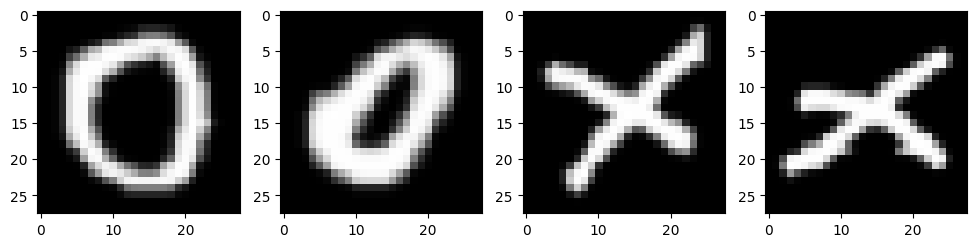

In [ ]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(12, 6))
ax1.imshow(emnist_train[0][0].reshape(28, 28), cmap='gray')
ax2.imshow(emnist_train[10][0].reshape(28, 28), cmap='gray')
ax3.imshow(emnist_train[4][0].reshape(28, 28), cmap='gray')
ax4.imshow(emnist_train[6][0].reshape(28, 28), cmap='gray')
plt.show()

### Multiple Filters

The following network sets up 3 filters and runs them on an image of the dataset from the  𝑋  class. The filters are 5x5 in size.

In [ ]:
class Net2(nn.Module):
  """
  Neural Network instance
  """

  def __init__(self, padding=0):
    """
    Initialize parameters of Net2

    Args:
      padding: int or tuple, optional
        Zero-padding added to both sides of the input. Default: 0

    Returns:
      Nothing
    """
    super(Net2, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=5,
                           padding=padding)

    # First kernel - leading diagonal
    kernel_1 = torch.Tensor([[[1., 1., -1., -1., -1.],
                              [1., 1., 1., -1., -1.],
                              [-1., 1., 1., 1., -1.],
                              [-1., -1., 1., 1., 1.],
                              [-1., -1., -1., 1., 1.]]])

    # Second kernel - other diagonal
    kernel_2 = torch.Tensor([[[-1., -1., -1., 1., 1.],
                              [-1., -1., 1., 1., 1.],
                              [-1., 1., 1., 1., -1.],
                              [1., 1., 1., -1., -1.],
                              [1., 1., -1., -1., -1.]]])

    # tThird kernel - checkerboard pattern
    kernel_3 = torch.Tensor([[[1., 1., -1., 1., 1.],
                              [1., 1., 1., 1., 1.],
                              [-1., 1., 1., 1., -1.],
                              [1., 1., 1., 1., 1.],
                              [1., 1., -1., 1., 1.]]])


    # Stack all kernels in one tensor with (3, 1, 5, 5) dimensions
    multiple_kernels = torch.stack([kernel_1, kernel_2, kernel_3], dim=0)

    self.conv1.weight = torch.nn.Parameter(multiple_kernels)

    # Negative bias
    self.conv1.bias = torch.nn.Parameter(torch.Tensor([-4, -4, -12]))

  def forward(self, x):
    """
    Forward Pass of Net2

    Args:
      x: torch.tensor
        Input features

    Returns:
      x: torch.tensor
        Convolution output
    """
    x = self.conv1(x)
    return x

**Note:** We add a negative bias to give a threshold to select the high output value, which corresponds to the features we want to detect (e.g., 45 degree oriented bar).

Now, let's visualize the filters using the code given below.

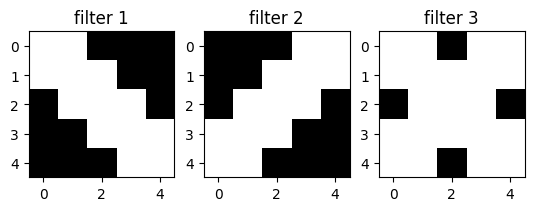

In [ ]:
net2 = Net2().to(DEVICE)
fig, (ax11, ax12, ax13) = plt.subplots(1, 3)
# Show the filters
ax11.set_title("filter 1")
ax11.imshow(net2.conv1.weight[0, 0].detach().cpu().numpy(), cmap="gray")
ax12.set_title("filter 2")
ax12.imshow(net2.conv1.weight[1, 0].detach().cpu().numpy(), cmap="gray")
ax13.set_title("filter 3")
ax13.imshow(net2.conv1.weight[2, 0].detach().cpu().numpy(), cmap="gray")

### Q 1.1.1 (4 pts)
In what way would these filters would help recognize an X?

**The first two filters can help recognize the diagonal patterns in an "X", while the third filter can help recognize the cross pattern at the center of "X". Together they help form the key features of an "X"**

### Applying Filters

Now let's apply the filters to the images.

In [ ]:
net2 = Net2().to(DEVICE)
x_img = emnist_train[x_img_idx][0].unsqueeze(dim=0).to(DEVICE)
output_x = net2(x_img)
output_x = output_x.squeeze(dim=0).detach().cpu().numpy()

o_img = emnist_train[o_img_idx][0].unsqueeze(dim=0).to(DEVICE)
output_o = net2(o_img)
output_o = output_o.squeeze(dim=0).detach().cpu().numpy()

Let us view the image of  𝑋  and  𝑂  and what the output of the filters applied to them looks like. Pay special attention to the areas with very high vs. very low output patterns.

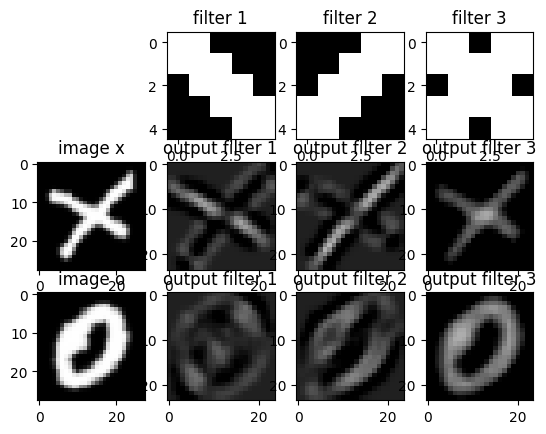

In [ ]:
fig, ((ax11, ax12, ax13, ax14),
      (ax21, ax22, ax23, ax24),
      (ax31, ax32, ax33, ax34)) = plt.subplots(3, 4)

# Show the filters
ax11.axis("off")
ax12.set_title("filter 1")
ax12.imshow(net2.conv1.weight[0, 0].detach().cpu().numpy(), cmap="gray")
ax13.set_title("filter 2")
ax13.imshow(net2.conv1.weight[1, 0].detach().cpu().numpy(), cmap="gray")
ax14.set_title("filter 3")
ax14.imshow(net2.conv1.weight[2, 0].detach().cpu().numpy(), cmap="gray")

vmin, vmax = -6, 10
# Show x and the filters applied to x
ax21.set_title("image x")
ax21.imshow(emnist_train[x_img_idx][0].reshape(28, 28), cmap='gray')
ax22.set_title("output filter 1")
ax22.imshow(output_x[0], cmap='gray', vmin=vmin, vmax=vmax)
ax23.set_title("output filter 2")
ax23.imshow(output_x[1], cmap='gray', vmin=vmin, vmax=vmax)
ax24.set_title("output filter 3")
ax24.imshow(output_x[2], cmap='gray', vmin=vmin, vmax=vmax)

# Show o and the filters applied to o
ax31.set_title("image o")
ax31.imshow(emnist_train[o_img_idx][0].reshape(28, 28), cmap='gray')
ax32.set_title("output filter 1")
ax32.imshow(output_o[0], cmap='gray', vmin=vmin, vmax=vmax)
ax33.set_title("output filter 2")
ax33.imshow(output_o[1], cmap='gray', vmin=vmin, vmax=vmax)
ax34.set_title("output filter 3")
ax34.imshow(output_o[2], cmap='gray', vmin=vmin, vmax=vmax)
plt.show()

### ReLU

The convolution operation is linear. But the real strength of neural networks comes from the incorporation of non-linear functions.  Furthermore, in the real world, we often have learning problems where the relationship between the input and output is non-linear and complex.

The ReLU (Rectified Linear Unit) introduces non-linearity into our model, allowing us to learn a more complex function that can better predict the class of an image.

Let's incorporate ReLU into our previous model.

In [ ]:
class Net3(nn.Module):
  """
  Neural Network Instance
  """

  def __init__(self, padding=0):
    """
    Initialize Net3 parameters

    Args:
      padding: int or tuple, optional
        Zero-padding added to both sides of the input. Default: 0

    Returns:
      Nothing
    """
    super(Net3, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=5,
                           padding=padding)

    # First kernel - leading diagonal
    kernel_1 = torch.Tensor([[[1., 1., -1., -1., -1.],
                              [1., 1., 1., -1., -1.],
                              [-1., 1., 1., 1., -1.],
                              [-1., -1., 1., 1., 1.],
                              [-1., -1., -1., 1., 1.]]])

    # Second kernel - other diagonal
    kernel_2 = torch.Tensor([[[-1., -1., -1., 1., 1.],
                              [-1., -1., 1., 1., 1.],
                              [-1., 1., 1., 1., -1.],
                              [1., 1., 1., -1., -1.],
                              [1., 1., -1., -1., -1.]]])

    # Third kernel -checkerboard pattern
    kernel_3 = torch.Tensor([[[1., 1., -1., 1., 1.],
                              [1., 1., 1., 1., 1.],
                              [-1., 1., 1., 1., -1.],
                              [1., 1., 1., 1., 1.],
                              [1., 1., -1., 1., 1.]]])


    # Stack all kernels in one tensor with (3, 1, 5, 5) dimensions
    multiple_kernels = torch.stack([kernel_1, kernel_2, kernel_3], dim=0)

    self.conv1.weight = torch.nn.Parameter(multiple_kernels)

    # Negative bias
    self.conv1.bias = torch.nn.Parameter(torch.Tensor([-4, -4, -12]))

  def forward(self, x):
    """
    Forward Pass of Net3

    Args:
      x: torch.tensor
        Input features

    Returns:
      x: torch.tensor
        Convolution output
    """
    x = self.conv1(x)
    x = F.relu(x)
    return x

Let's apply the filters and ReLUs to the images.

In [ ]:
net3 = Net3().to(DEVICE)
x_img = emnist_train[x_img_idx][0].unsqueeze(dim=0).to(DEVICE)
output_x_relu = net3(x_img)
output_x_relu = output_x_relu.squeeze(dim=0).detach().cpu().numpy()

o_img = emnist_train[o_img_idx][0].unsqueeze(dim=0).to(DEVICE)
output_o_relu = net3(o_img)
output_o_relu = output_o_relu.squeeze(dim=0).detach().cpu().numpy()

Let us view the image of  𝑋  and  𝑂  and what the output of the filters applied to them look like.

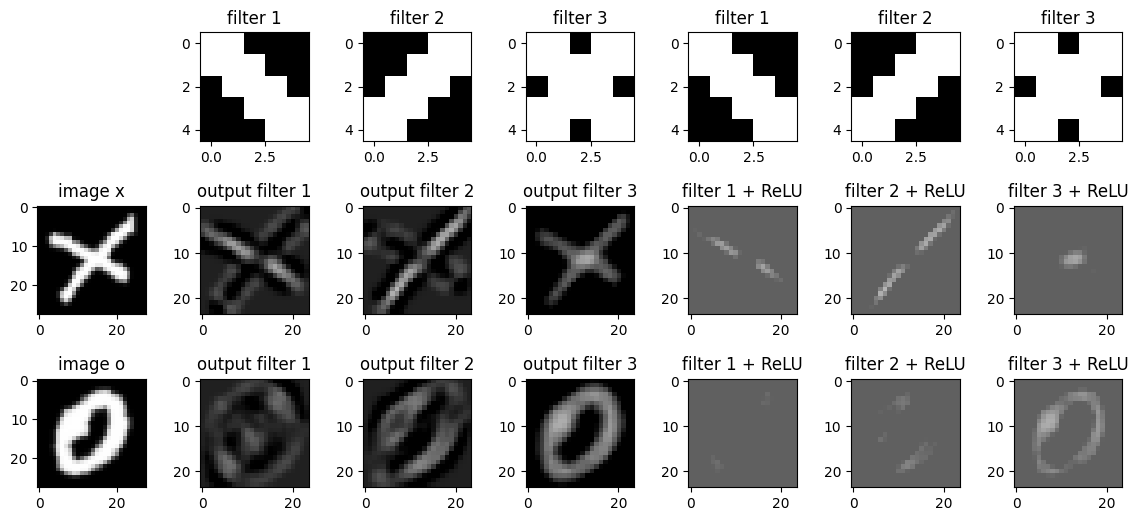

In [ ]:
fig, ((ax11, ax12, ax13, ax14, ax15, ax16, ax17),
      (ax21, ax22, ax23, ax24, ax25, ax26, ax27),
      (ax31, ax32, ax33, ax34, ax35, ax36, ax37)) = plt.subplots(3, 4 + 3,
                                                                 figsize=(14, 6))
# Show the filters
ax11.axis("off")
ax12.set_title("filter 1")
ax12.imshow(net3.conv1.weight[0, 0].detach().cpu().numpy(), cmap="gray")
ax13.set_title("filter 2")
ax13.imshow(net3.conv1.weight[1, 0].detach().cpu().numpy(), cmap="gray")
ax14.set_title("filter 3")
ax14.imshow(net3.conv1.weight[2, 0].detach().cpu().numpy(), cmap="gray")

ax15.set_title("filter 1")
ax15.imshow(net3.conv1.weight[0, 0].detach().cpu().numpy(), cmap="gray")
ax16.set_title("filter 2")
ax16.imshow(net3.conv1.weight[1, 0].detach().cpu().numpy(), cmap="gray")
ax17.set_title("filter 3")
ax17.imshow(net3.conv1.weight[2, 0].detach().cpu().numpy(), cmap="gray")

vmin, vmax = -6, 10
# Show x and the filters applied to `x`
ax21.set_title("image x")
ax21.imshow(emnist_train[x_img_idx][0].reshape(28, 28), cmap='gray')
ax22.set_title("output filter 1")
ax22.imshow(output_x[0], cmap='gray', vmin=vmin, vmax=vmax)
ax23.set_title("output filter 2")
ax23.imshow(output_x[1], cmap='gray', vmin=vmin, vmax=vmax)
ax24.set_title("output filter 3")
ax24.imshow(output_x[2], cmap='gray', vmin=vmin, vmax=vmax)

ax25.set_title("filter 1 + ReLU")
ax25.imshow(output_x_relu[0], cmap='gray', vmin=vmin, vmax=vmax)
ax26.set_title("filter 2 + ReLU")
ax26.imshow(output_x_relu[1], cmap='gray', vmin=vmin, vmax=vmax)
ax27.set_title("filter 3 + ReLU")
ax27.imshow(output_x_relu[2], cmap='gray', vmin=vmin, vmax=vmax)

# Show o and the filters applied to `o`
ax31.set_title("image o")
ax31.imshow(emnist_train[o_img_idx][0].reshape(28, 28), cmap='gray')
ax32.set_title("output filter 1")
ax32.imshow(output_o[0], cmap='gray', vmin=vmin, vmax=vmax)
ax33.set_title("output filter 2")
ax33.imshow(output_o[1], cmap='gray', vmin=vmin, vmax=vmax)
ax34.set_title("output filter 3")
ax34.imshow(output_o[2], cmap='gray', vmin=vmin, vmax=vmax)

ax35.set_title("filter 1 + ReLU")
ax35.imshow(output_o_relu[0], cmap='gray', vmin=vmin, vmax=vmax)
ax36.set_title("filter 2 + ReLU")
ax36.imshow(output_o_relu[1], cmap='gray', vmin=vmin, vmax=vmax)
ax37.set_title("filter 3 + ReLU")
ax37.imshow(output_o_relu[2], cmap='gray', vmin=vmin, vmax=vmax)
plt.subplots_adjust(wspace=0.5,hspace=0.5)
plt.show()

### Q 1.1.2 (4 pts)

How do the ReLU activations help strengthen the features necessary to detect an  𝑋 ?

**It further reduces noises and thus emphasizes key features extracted from each filter, which help generate a sharper contrast between the pattern and the background.**

### Pooling

Convolutional layers create feature maps that summarize the presence of particular features (e.g., edges) in the input. However, these feature maps record the precise position of features in the input. That means that small changes to the position of an object in an image can result in a very different feature map. But a cup is a cup (and an  𝑋  is an  𝑋 ) no matter where it appears in the image! We need to achieve translational invariance.

A common approach to this problem is called downsampling. Downsampling creates a lower-resolution version of an image, retaining the large structural elements and removing some of the fine detail that may be less relevant to the task. In CNNs, Max-Pooling and Average-Pooling are used to downsample. These operations shrink the size of the hidden layers, and produce features that are more translationally invariant, which can be better leveraged by subsequent layers.

Like convolutional layers, pooling layers have fixed-shape windows (pooling windows) that are systematically applied to the input. As with filters, we can change the shape of the window and the size of the stride. And, just like with filters, every time we apply a pooling operation we produce a single output.

Pooling performs a kind of information compression that provides summary statistics for a neighborhood of the input.

In Maxpooling, we compute the maximum value of all pixels in the pooling window.
In Avgpooling, we compute the average value of all pixels in the pooling window.

Pooling also gives our network translational invariance by providing a summary of the values in each pooling window. Thus, a small change in the features of the underlying image won't make a huge difference to the output.

Note that, unlike a convolutional layer, the pooling layer contains no learned parameters! Pooling just computes a pre-determined summary of the input and passes that along. This is in contrast to the convolutional layer, where there are filters to be learned.

### Maxpool

Let us now implement MaxPooling in PyTorch and observe the effects of Pooling on the dimension of the input image. Use a kernel of size 2 and stride of 2 for the MaxPooling layer.

In [ ]:
class Net4(nn.Module):
  """
  Neural Network instance
  """

  def __init__(self, padding=0, stride=2):
    """
    Initialise parameters of Net4

    Args:
      padding: int or tuple, optional
        Zero-padding added to both sides of the input. Default: 0
      stride: int
        Stride

    Returns:
      Nothing
    """
    super(Net4, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=5,
                            padding=padding)

    # First kernel - leading diagonal
    kernel_1 = torch.Tensor([[[1., 1., -1., -1., -1.],
                              [1., 1., 1., -1., -1.],
                              [-1., 1., 1., 1., -1.],
                              [-1., -1., 1., 1., 1.],
                              [-1., -1., -1., 1., 1.]]])

    # Second kernel - other diagonal
    kernel_2 = torch.Tensor([[[-1., -1., -1., 1., 1.],
                              [-1., -1., 1., 1., 1.],
                              [-1., 1., 1., 1., -1.],
                              [1., 1., 1., -1., -1.],
                              [1., 1., -1., -1., -1.]]])

    # Third kernel -checkerboard pattern
    kernel_3 = torch.Tensor([[[1., 1., -1., 1., 1.],
                              [1., 1., 1., 1., 1.],
                              [-1., 1., 1., 1., -1.],
                              [1., 1., 1., 1., 1.],
                              [1., 1., -1., 1., 1.]]])


    # Stack all kernels in one tensor with (3, 1, 5, 5) dimensions
    multiple_kernels = torch.stack([kernel_1, kernel_2, kernel_3], dim=0)

    self.conv1.weight = torch.nn.Parameter(multiple_kernels)

    # Negative bias
    self.conv1.bias = torch.nn.Parameter(torch.Tensor([-4, -4, -12]))
    ####################################################################
    # Fill in missing code below (...),
    # then remove or comment the line below to test your function
    # raise NotImplementedError("Define the maxpool layer")
    ####################################################################
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

  def forward(self, x):
    """
    Forward Pass of Net4

    Args:
      x: torch.tensor
        Input features

    Returns:
      x: torch.tensor
        Convolution + ReLU output
    """
    x = self.conv1(x)
    x = F.relu(x)
    ####################################################################
    # Fill in missing code below (...),
    # then remove or comment the line below to test your function
    # raise NotImplementedError("Define the maxpool layer")
    ####################################################################
    x = self.pool(x)  # Pass through a max pool layer
    return x



## Uncomment below to check if your implementation is correct
net4 = Net4().to(DEVICE)
check_pooling_net(net4, device=DEVICE)

✅ Your network produced the correct output.


### Ready

Run the following to get the outputs from your network.

In [ ]:
x_img = emnist_train[x_img_idx][0].unsqueeze(dim=0).to(DEVICE)
output_x_pool = net4(x_img)
output_x_pool = output_x_pool.squeeze(dim=0).detach().cpu().numpy()

o_img = emnist_train[o_img_idx][0].unsqueeze(dim=0).to(DEVICE)
output_o_pool = net4(o_img)
output_o_pool = output_o_pool.squeeze(dim=0).detach().cpu().numpy()

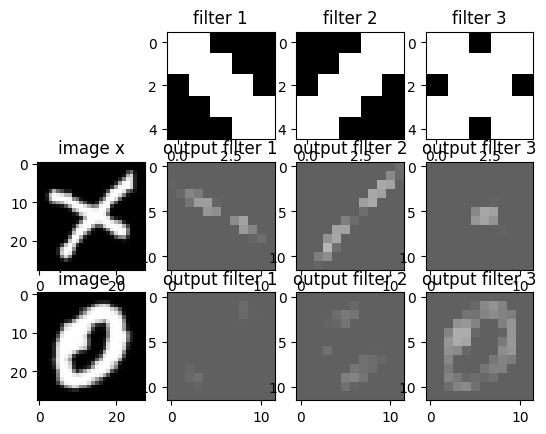

In [ ]:
# @title Run to plot the outputs

fig, ((ax11, ax12, ax13, ax14),
      (ax21, ax22, ax23, ax24),
      (ax31, ax32, ax33, ax34)) = plt.subplots(3, 4)
# Show the filters
ax11.axis("off")
ax12.set_title("filter 1")
ax12.imshow(net4.conv1.weight[0, 0].detach().cpu().numpy(), cmap="gray")
ax13.set_title("filter 2")
ax13.imshow(net4.conv1.weight[1, 0].detach().cpu().numpy(), cmap="gray")
ax14.set_title("filter 3")
ax14.imshow(net4.conv1.weight[2, 0].detach().cpu().numpy(), cmap="gray")

vmin, vmax = -6, 10
# Show x and the filters applied to x
ax21.set_title("image x")
ax21.imshow(emnist_train[x_img_idx][0].reshape(28, 28), cmap='gray')
ax22.set_title("output filter 1")
ax22.imshow(output_x_pool[0], cmap='gray', vmin=vmin, vmax=vmax)
ax23.set_title("output filter 2")
ax23.imshow(output_x_pool[1], cmap='gray', vmin=vmin, vmax=vmax)
ax24.set_title("output filter 3")
ax24.imshow(output_x_pool[2], cmap='gray', vmin=vmin, vmax=vmax)

# Show o and the filters applied to o
ax31.set_title("image o")
ax31.imshow(emnist_train[o_img_idx][0].reshape(28, 28), cmap='gray')
ax32.set_title("output filter 1")
ax32.imshow(output_o_pool[0], cmap='gray', vmin=vmin, vmax=vmax)
ax33.set_title("output filter 2")
ax33.imshow(output_o_pool[1], cmap='gray', vmin=vmin, vmax=vmax)
ax34.set_title("output filter 3")
ax34.imshow(output_o_pool[2], cmap='gray', vmin=vmin, vmax=vmax)
plt.show()

### Q 1.1.3 (4 pts)

What is the size of the output now relative to what you saw after the ReLU section? Did the change in size impact the important or high-level features in the output?

**The size is smaller (from 20 to 10). This makes the resolution of images lower, but did not impact the high-level features extracted in the output.**

### Parameter sharing

Convolutional networks encourage weight-sharing by learning a single kernel that is repeated over the entire input image. In general, this kernel is just a few parameters, compared to the huge number of parameters in a dense network.

While pooling does not reduce the number of parameters for a subsequent convolutional layer, it does decreases the image size. Therefore, later dense layers will need fewer parameters.

The CNN parameter size, however, is invariant of the image size, as irrespective of the input that it gets, it keeps sliding the same learnable filter over the images.

The reduced parameter set not only brings down memory usage by huge chunks, but it also allows the model to generalize better.

## 1.2 Implement Your Own

Let's stack up all we have learnt. Create a CNN with the following structure. <br>
- Convolution `nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)`
- Convolution `nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)`
- Pool Layer `nn.MaxPool2d(kernel_size=2)`
- Fully Connected Layer `nn.Linear(in_features=9216, out_features=128)`
- Fully Connected layer `nn.Linear(in_features=128, out_features=2)`

Note: We would like to flatten the output from the Convolutional Layers before passing on the Linear layers, thereby converting an input of shape $[\text{BatchSize}, \text{Channels}, \text{Height}, \text{Width}]$ to $[\text{BatchSize}, \text{Channels} \times \text{Height} \times \text{Width}]$, which in this case would be from $[32, 64, 12, 12]$ (output of second convolution layer) to $[32, 64 \times 12 \times 12] = [32, 9216]$. Recall that the input images have size $[28, 28]$.

Hint: You could use `torch.flatten(x, 1)` in order to flatten the input at this stage. The $1$ means it flattens dimensions starting with dimensions 1 in order to exclude the batch dimension from the flattening.

We should also stop to think about how we get the output of the pooling layer to be $12 \times 12$. It is because first, the two `Conv2d` with a `kernel_size=3` operations cause the image to be reduced to $26 \times 26$ and the second `Conv2d` reduces it to $24 \times 24$. Finally, the `MaxPool2d` operation reduces the output size by half to $12 \times 12$.

Also, don't forget the ReLUs (use e.g., `F.ReLU`)! No need to add a ReLU after the final fully connected layer.

In [ ]:
# @title Train/Test Functions (Run Me)

def train(model, device, train_loader, epochs):
  """
  Training function

  Args:
    model: nn.module
      Neural network instance
    device: string
      GPU/CUDA if available, CPU otherwise
    epochs: int
      Number of epochs
    train_loader: torch.loader
      Training Set

  Returns:
    Nothing
  """
  model.train()

  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
  for epoch in range(epochs):
    with tqdm(train_loader, unit='batch') as tepoch:
      for data, target in tepoch:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)

        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        tepoch.set_postfix(loss=loss.item())
        time.sleep(0.1)

def test(model, device, data_loader):
  """
  Test function

  Args:
    model: nn.module
      Neural network instance
    device: string
      GPU/CUDA if available, CPU otherwise
    data_loader: torch.loader
      Test Set

  Returns:
    acc: float
      Test accuracy
  """
  model.eval()
  correct = 0
  total = 0
  for data in data_loader:
    inputs, labels = data
    inputs = inputs.to(device).float()
    labels = labels.to(device).long()

    outputs = model(inputs)
    _, predicted = torch.max(outputs, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

  acc = 100 * correct / total
  return acc

Run the following to download the data. Notice that here, we normalize the dataset.

In [ ]:
set_seed(SEED)
emnist_train, emnist_test = get_Xvs0_dataset(normalize=True)
train_loader, test_loader = get_data_loaders(emnist_train, emnist_test,
                                             seed=SEED)

Random seed 2025 has been set.


### Q 1.2.1: Build CNN (10 pts)

Complete the following class initialization for your custom CNN and its forward pass function.

In [ ]:
class EMNIST_Net(nn.Module):
  """
  Neural network instance with following structure
  nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3) # Convolutional Layer 1
  nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3) + max-pooling # Convolutional Block 2
  nn.Linear(in_features=9216, out_features=128) # Fully Connected Layer 1
  nn.Linear(in_features=128, out_features=2) # Fully Connected Layer 2
  """

  def __init__(self):
    """
    Initialize parameters of EMNISTNet

    Args:
      None

    Returns:
      Nothing
    """
    super(EMNIST_Net, self).__init__()

    ####################################################################
    # Fill in missing code below (...),
    # then remove or comment the line below to test your function
    # raise NotImplementedError("Define the required layers")
    ####################################################################
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
    self.fc1 = nn.Linear(in_features=9216, out_features=128)
    self.fc2 = nn.Linear(in_features=128, out_features=2)
    self.pool = nn.MaxPool2d(kernel_size=2)

  def forward(self, x):
    """
    Forward pass of EMNISTNet

    Args:
      x: torch.tensor
        Input features

    Returns:
      x: torch.tensor
        Output of final fully connected layer
    """
    ####################################################################
    # Fill in missing code below (...),
    # then remove or comment the line below to test your function
    # Hint: Do not forget to flatten the image as it goes from
    # Convolution Layers to Linear Layers!
    # raise NotImplementedError("Define forward pass for any input x")
    ####################################################################
    x = self.conv1(x)
    x = F.relu(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = self.pool(x)
    x = torch.flatten(x, 1)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.fc2(x)
    return x



## Uncomment the lines below to train your network
emnist_net = EMNIST_Net().to(DEVICE)
print("Total Parameters in Network {:10d}".format(sum(p.numel() for p in emnist_net.parameters())))
train(emnist_net, DEVICE, train_loader, 1)
## Uncomment to test your model
print(f'Test accuracy is: {test(emnist_net, DEVICE, test_loader)}')

Total Parameters in Network    1198850


  0%|          | 0/300 [00:00<?, ?batch/s]

Test accuracy is: 99.125


You should have been able to get a test accuracy of around  99!

Note: We are using a softmax function here which converts a real value to a value between 0 and 1, which can be interpreted as a probability.

Input:


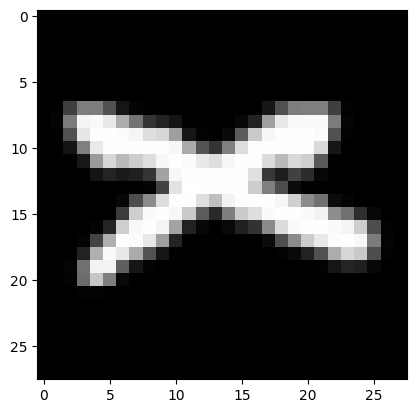


Result: tensor([[6.0832e-04, 9.9939e-01]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
Confidence of image being an 'O': 0.0006083150510676205
Confidence of image being an 'X': 0.9993916749954224


In [ ]:
# Index of an image in the dataset that corresponds to an X and O
x_img_idx = 11
o_img_idx = 0

print("Input:")
x_img = emnist_train[x_img_idx][0].unsqueeze(dim=0).to(DEVICE)
plt.imshow(emnist_train[x_img_idx][0].reshape(28, 28),
           cmap=plt.get_cmap('gray'))
plt.show()
output = emnist_net(x_img)
result = F.softmax(output, dim=1)
print("\nResult:", result)
print("Confidence of image being an 'O':", result[0, 0].item())
print("Confidence of image being an 'X':", result[0, 1].item())

The network is quite confident that this image is an  𝑋 !

Note that this is evident from the softmax output, which shows the probabilities of the image belonging to each of the classes. There is a higher probability of belonging to class 1; i.e., class  𝑋 .

Let us also test the network on an  𝑂  image.

Input:


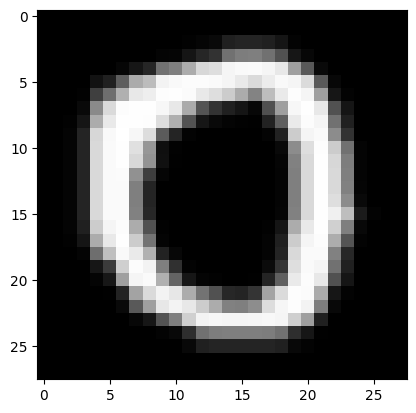


Result: tensor([[9.9944e-01, 5.6017e-04]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
Confidence of image being an 'O': 0.9994397759437561
Confidence of image being an 'X': 0.0005601749871857464


In [ ]:
print("Input:")
o_img = emnist_train[o_img_idx][0].unsqueeze(dim=0).to(DEVICE)
plt.imshow(emnist_train[o_img_idx][0].reshape(28, 28),
           cmap=plt.get_cmap('gray'))
plt.show()
output = emnist_net(o_img)
result = F.softmax(output, dim=1)
print("\nResult:", result)
print("Confidence of image being an 'O':", result[0, 0].item())
print("Confidence of image being an 'X':", result[0, 1].item())

### Training loop

We've now coded up a CNN, but we trained it with some predefined functions. In this section, we will walk through an example of training loop for a convolution net. We will train a CNN using convolution layers and maxpool and then observe what the training and validation curves look like.

### Data

The dataset we are going to use for this task is called Fashion-MNIST. It consists of a training set of 60,000 examples and a test set of 10,000 examples. We further divide the test set into a validation set and a test set (8,000 and 2,000, respectively). Each example is a $28 \times 28$ gray scale image, associated with a label from 10 classes. Following are the labels of the dataset:

<br>

\begin{matrix}
\text{label} && \text{category} \\
\hline
0 && \text{T-shirt/top} \\
1 && \text{Trouser} \\
2 && \text{Pullover} \\
3 && \text{Dress} \\
4 && \text{Coat} \\
5 && \text{Sandal} \\
6 && \text{Shirt} \\
7 && \text{Sneaker} \\
8 && \text{Bag} \\
9 && \text{Ankle boot} \\
\end{matrix}

**Note:** We will reduce the dataset to just the two categories T-shirt/top and Shirt to reduce the training time from about 10min to 2min. We'll later look at pretrained results to get an idea of how the results would look on the whole dataset.

In [ ]:
# @title Download Fashion MNIST dataset

# webpage: https://github.com/zalandoresearch/fashion-mnist
fname = 'FashionMNIST.tar.gz'
folder = 'FashionMNIST'
url = "https://osf.io/dfhu5/download"
download_data(fname, folder, url, tar=True)




Extracting the files...



In [ ]:
# @title Loading Fashion-MNIST Data

# @markdown `reduce_classes(data)` to reduce Fashion-MNIST Data to two-categories

# need to split into train, validation, test
def reduce_classes(data):
  """
  Reducing classes in Fashion MNIST
  to T-Shirts and Shirts

  Args:
    data: torch.tensor
      Training Data

  Returns:
    data: torch.tensor
      Data with two classes
  """
  # Only want T-Shirts (0) and Shirts (6) labels
  train_idx = (data.targets == 0) | (data.targets == 6)
  data.targets = data.targets[train_idx]
  data.data = data.data[train_idx]

  # Convert Xs predictions to 1, Os predictions to 0
  data.targets[data.targets == 6] = 1

  return data


def get_fashion_mnist_dataset(binary=False, download=False, seed=0):
  """
  Helper function to get Fashion MNIST data

  Args:
    binary: boolean
      If True, training data has only two classes
    download: boolean
      If True, download training data
    seed: int
      Set seed for reproducibility [default: 0]

  Returns:
    train_data: torch.tensor
      Training data
    test_data: torch.tensor
      Test data
    validation_data: torch.tensor
      Validation data
  """
  transform = transforms.Compose([
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.1307,), (0.3081,))
                                  ])

  train_data = datasets.FashionMNIST(root='.',
                                     download=download,
                                     train=True,
                                     transform=transform)


  test_data = datasets.FashionMNIST(root='.',
                                    download=download,
                                    train=False,
                                    transform=transform)

  if binary:
    train_data = reduce_classes(train_data)
    test_data = reduce_classes(test_data)

  set_seed(seed)
  validation_data, test_data = torch.utils.data.random_split(test_data,
                                                             [int(0.8*len(test_data)),
                                                              int(0.2*len(test_data))])

  return train_data, validation_data, test_data

In [ ]:
num_classes = 10
train_data, validation_data, test_data = get_fashion_mnist_dataset(seed=SEED)

Random seed 2025 has been set.


If you want to continue with the 10 class dataset, skip the next cell.

In [ ]:
num_classes = 2
train_data, validation_data, test_data = get_fashion_mnist_dataset(binary=True, seed=SEED)

Random seed 2025 has been set.


Here's some code to visualize the dataset.

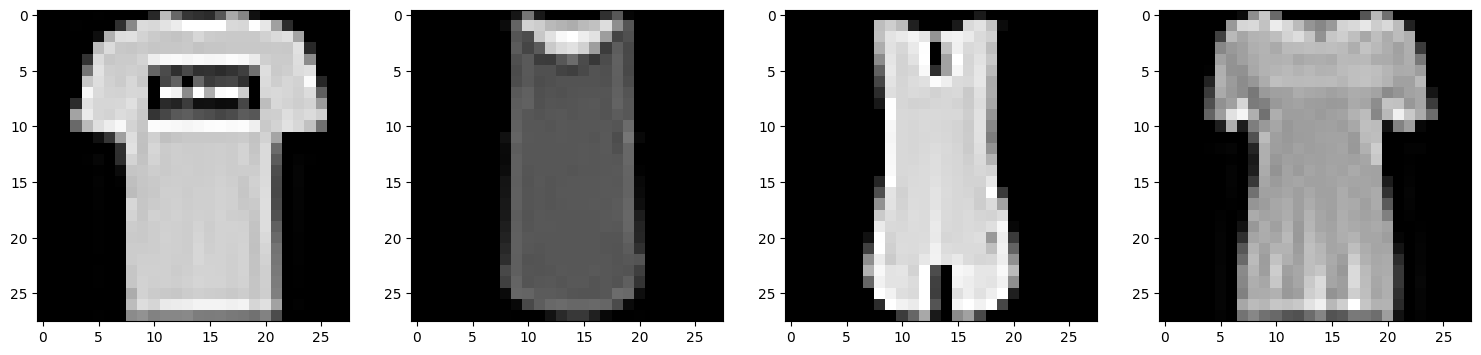

In [ ]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
ax1.imshow(train_data[0][0].reshape(28, 28), cmap=plt.get_cmap('gray'))
ax2.imshow(train_data[1][0].reshape(28, 28), cmap=plt.get_cmap('gray'))
ax3.imshow(train_data[2][0].reshape(28, 28), cmap=plt.get_cmap('gray'))
ax4.imshow(train_data[3][0].reshape(28, 28), cmap=plt.get_cmap('gray'))
fig.set_size_inches(18.5, 10.5)
plt.show()

### Q 1.2.2: Classes (4 pts)
Which classes do you think would be most confusable? How hard will it be to differentiate t-shirt/tops from shirts?

**I think the tops vs. dresses or the pullovers vs. coats would be the most confusable because these pairs have similar shapes and key features. To differentiate t-shirts/tops from shirts might be easier because the sleeve length can be a key element to distinguish.**

### Backprop

We know that we multiply the input data/tensors with weight matrices to obtain some output. Initially, we don't know what the actual weight matrices are so we initialize them with some random values. These random weight matrices when applied as a transformation on the input gives us some output. At first the outputs/predictions will match the true labels only by chance.

To improve performance, we need to change the weight matrices so that the predicted outputs are similar to the true outputs (labels). We first calculate how far away the predicted outputs are to the true outputs using a loss function. Based on the loss function, we change the values of our weight matrices using the gradients of the error with respect to the weight matrices.

Since we are using PyTorch now, we will use the built-in functions to update the weights. We call the backward() method on our 'loss' variable to calculate the gradients/derivatives with respect to all the weight matrices and biases. And then we call the step() method on the optimizer variable to apply the gradient updates to our weight matrices.

### Sample Training Loop
Let's first see a sample training loop. First, we create the network and load a dataset. Then we look at the training loop.

In [ ]:
class emnist_net(nn.Module):
  """
  Create a sample network
  """

  def __init__(self):
    """
    Initialise parameters of sample network

    Args:
      None

    Returns:
      Nothing
    """
    super().__init__()
    # First define the layers.
    self.conv1 = nn.Conv2d(1, 32, kernel_size=5, padding=2)
    self.conv2 = nn.Conv2d(32, 64, kernel_size=5, padding=2)
    self.fc1 = nn.Linear(7 * 7 * 64, 256)
    self.fc2 = nn.Linear(256, 26)

  def forward(self, x):
    """
    Forward pass of sample network

    Args:
      x: torch.tensor
        Input features

    Returns:
      x: torch.tensor
        Output after passing through sample network
    """
    # Conv layer 1.
    x = self.conv1(x)
    x = F.relu(x)
    x = F.max_pool2d(x, kernel_size=2)

    # Conv layer 2.
    x = self.conv2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, kernel_size=2)

    # Fully connected layer 1.
    x = x.view(-1, 7 * 7 * 64)  # You have to first flatten the ourput from the
                            # previous convolution layer.
    x = self.fc1(x)
    x = F.relu(x)

    # Fully connected layer 2.
    x = self.fc2(x)

    return x

In [ ]:
# @title Load a sample dataset (EMNIST)
# Download the data if there are not downloaded
fname = 'EMNIST.zip'
folder = 'EMNIST'
url = "https://osf.io/xwfaj/download"
download_data(fname, folder, url, tar=False)

mnist_train = datasets.EMNIST(root=".",
                              train=True,
                              transform=transforms.ToTensor(),
                              download=False,
                              split='letters')
mnist_test = datasets.EMNIST(root=".",
                             train=False,
                             transform=transforms.ToTensor(),
                             download=False,
                             split='letters')

# Labels should start from 0
mnist_train.targets -= 1
mnist_test.targets -= 1

# Create data loaders
g_seed = torch.Generator()
g_seed.manual_seed(SEED)

train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=100,
                                           shuffle=False,
                                           num_workers=2,
                                           worker_init_fn=seed_worker,
                                           generator=g_seed)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=100,
                                          shuffle=False,
                                          num_workers=2,
                                          worker_init_fn=seed_worker,
                                          generator=g_seed)

EMNIST dataset has already been downloaded.



In [ ]:
# Training
# Instantiate model
# Puts the Model on the GPU (Select runtime-type as GPU
#                            from the 'Runtime->Change Runtime type' option).

model = emnist_net().to(DEVICE)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Make changes here, if necessary

# Iterate through train set minibatchs
for epoch in trange(3):  # Make changes here, if necessary
  for images, labels in tqdm(train_loader):

    # Zero out the gradients
    optimizer.zero_grad()

    # Forward pass
    x = images
    # Move the data to GPU for faster execution.
    x, labs = x.to(DEVICE), labels.to(DEVICE)
    y = model(x)

    # Calculate loss.
    loss = criterion(y, labs)

    # Backpropagation and gradient update.
    loss.backward() # Calculate gradients.
    optimizer.step() # Apply gradient udpate.


## Testing
correct = 0
total = len(mnist_test)

with torch.no_grad():
  # Iterate through test set minibatchs
  for images, labels in tqdm(test_loader):
    # Forward pass
    x = images
      # Move the data to GPU for faster execution.
    x, labs = x.to(DEVICE), labels.to(DEVICE)
    y = model(x)

    predictions = torch.argmax(y, dim=1)
    correct += torch.sum((predictions == labs).float())

print(f'Test accuracy: {correct / total * 100:.2f}%')

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1248 [00:00<?, ?it/s]

  0%|          | 0/1248 [00:00<?, ?it/s]

  0%|          | 0/1248 [00:00<?, ?it/s]

  0%|          | 0/208 [00:00<?, ?it/s]

Test accuracy: 92.82%


### Implementation Steps

You already coded the structure of a CNN. Below, you are going to implement the training loop for a CNN.
- Choose the correct criterion
- Code up the training part (calculating gradients, loss, stepping forward)
- Keep a track of the running loss i.e for each epoch we want to to know the average loss of the batch size. We have already done the same for accuracy for you.



### Fashion MNIST
We'll be training on the actual Fashion-MNIST dataset.

In [ ]:
# @markdown ##### Getting the DataLoaders (Run Me)


def get_data_loaders(train_dataset, validation_dataset,
                     test_dataset, seed,
                     batch_size=64):
  """
  Helper function to fetch dataloaders

  Args:
    train_dataset: torch.tensor
      Training data
    test_dataset: torch.tensor
      Test data
    validation_dataset: torch.tensor
      Validation data
    batch_size: int
      Batch Size  [default: 64]
    seed: int
      Set seed for reproducibility

  Returns:
    train_loader: torch.loader
      Training Data
    test_loader: torch.loader
      Test Data
    validation_loader: torch.loader
      Validation Data
  """

  g_seed = torch.Generator()
  g_seed.manual_seed(seed)

  train_loader = DataLoader(train_dataset,
                            batch_size=batch_size,
                            shuffle=True,
                            num_workers=2,
                            worker_init_fn=seed_worker,
                            generator=g_seed)
  validation_loader = DataLoader(validation_dataset,
                                 batch_size=batch_size,
                                 shuffle=True,
                                 num_workers=2,
                                 worker_init_fn=seed_worker,
                                 generator=g_seed)
  test_loader = DataLoader(test_dataset,
                           batch_size=batch_size,
                           shuffle=True,
                           num_workers=2,
                           worker_init_fn=seed_worker,
                           generator=g_seed)

  return train_loader, validation_loader, test_loader


train_loader, validation_loader, test_loader = get_data_loaders(train_data,
                                                                validation_data,
                                                                test_data, SEED)

In [ ]:
class FMNIST_Net1(nn.Module):
  """
  Convolutional Neural Network
  """

  def __init__(self, num_classes):
    """
    Initialise parameters of CNN

    Args:
      num_classes: int
        Number of classes

    Returns:
      Nothing
    """
    super(FMNIST_Net1, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, 3, 1)
    self.conv2 = nn.Conv2d(32, 64, 3, 1)
    self.fc1 = nn.Linear(9216, 128)
    self.fc2 = nn.Linear(128, num_classes)

  def forward(self, x):
    """
    Forward pass of CNN

    Args:
      x: torch.tensor
        Input features

    Returns:
      x: torch.tensor
        Output after passing through CNN
    """
    x = self.conv1(x)
    x = F.relu(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 2)
    x = torch.flatten(x, 1)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.fc2(x)

    return x

### Q 1.2.3: Implement Training (10 pts)

You should first define a criterion (you can use CrossEntropyLoss) so that you can calculate the loss. Next, you should to put everything together. Start the training process by first obtaining the model output, calculating the loss, and finally updating the weights.

Don't forget to zero out the gradients.

Note: The comments in the train function provides many hints that will help you fill in the missing code. This will give you a solid understanding of the different steps involved in the training loop.

Random seed 2025 has been set.


  0%|          | 0/20 [00:00<?, ?epoch/s]

Test accuracy is: 88.5


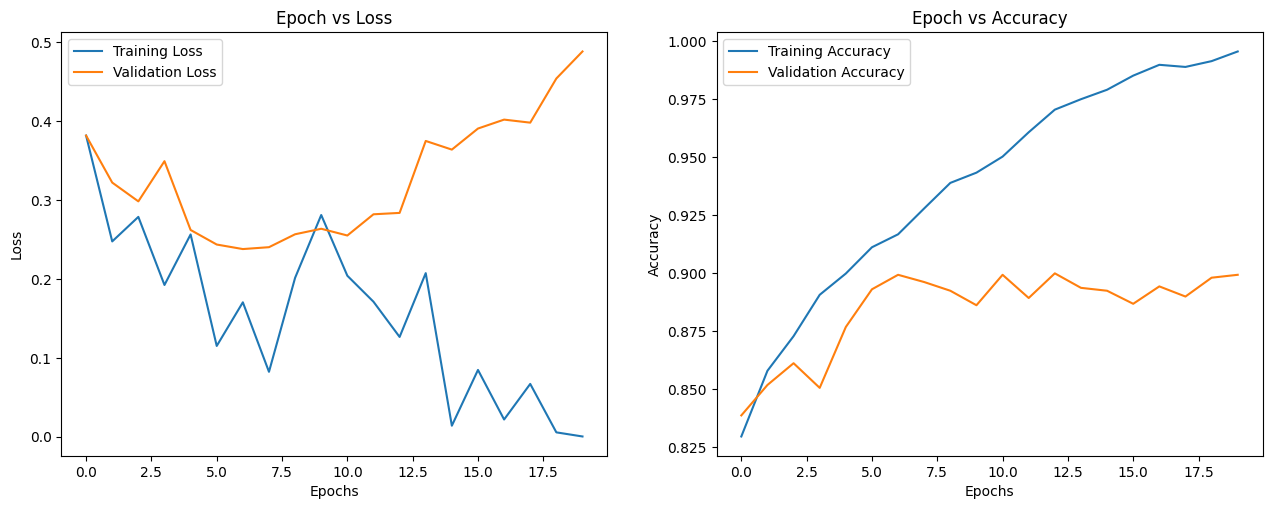

In [ ]:
def train(model, device, train_loader, validation_loader, epochs):
  """
  Training loop

  Args:
    model: nn.module
      Neural network instance
    device: string
      GPU/CUDA if available, CPU otherwise
    epochs: int
      Number of epochs
    train_loader: torch.loader
      Training Set
    validation_loader: torch.loader
      Validation set

  Returns:
    Nothing
  """
  criterion =  nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
  train_loss, validation_loss = [], []
  train_acc, validation_acc = [], []
  with tqdm(range(epochs), unit='epoch') as tepochs:
    tepochs.set_description('Training')
    for epoch in tepochs:
      model.train()
      # Keeps track of the running loss
      running_loss = 0.
      correct, total = 0, 0
      for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        ####################################################################
        # Fill in missing code below (...),
        # then remove or comment the line below to test your function
        # raise NotImplementedError("Update the steps of the train loop")
        ####################################################################
        # COMPLETE CODE FOR TRAINING LOOP by following these steps
        # 1. Get the model output (call the model with the data from this batch)
        output = model(data)

        # 2. Zero the gradients out (i.e. reset the gradient that the optimizer
        #                       has collected so far with optimizer.zero_grad())
        optimizer.zero_grad(True)

        # 3. Get the Loss (call the loss criterion with the model's output
        #                  and the target values)
        loss = criterion(output, target)

        # 4. Calculate the gradients (do the pass backwards from the loss
        #                             with loss.backward())
        grads = loss.backward()

        # 5. Update the weights (using the training step of the optimizer,
        #                        optimizer.step())
        optimizer.step()

        ####################################################################
        # Fill in missing code below (...),
        # then remove or comment the line below to test your function
        # raise NotImplementedError("Update the set_postfix function")
        ####################################################################
        # Set loss to whatever you end up naming your variable when
        # calling criterion
        # For example, loss = criterion(output, target)
        # then set loss = loss.item() in the set_postfix function
        tepochs.set_postfix(loss=loss.item())
        running_loss += loss.item()  # Add the loss for this batch

        # Get accuracy
        _, predicted = torch.max(output, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

      ####################################################################
      # Fill in missing code below (...),
      # then remove or comment the line below to test your function
      # raise NotImplementedError("Append the train_loss")
      ####################################################################
      train_loss.append(loss.item())  # Append the loss for this epoch (running loss divided by the number of batches e.g. len(train_loader))
      train_acc.append(correct / total)

      # Evaluate on validation data
      model.eval()
      running_loss = 0.
      correct, total = 0, 0
      for data, target in validation_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        tepochs.set_postfix(loss=loss.item())
        running_loss += loss.item()
        # Get accuracy
        _, predicted = torch.max(output, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

      validation_loss.append(running_loss / len(validation_loader))
      validation_acc.append(correct / total)

  return train_loss, train_acc, validation_loss, validation_acc


set_seed(SEED)
## Uncomment to test your training loop
net = FMNIST_Net1(num_classes=2).to(DEVICE)
train_loss, train_acc, validation_loss, validation_acc = train(net, DEVICE, train_loader, validation_loader, 20)
print(f'Test accuracy is: {test(net, DEVICE, test_loader)}')
plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc)

### Q 1.2.4: Overfitting (4 pts)

Do you think this network is overfitting? If yes, what can you do to combat this?

**Since the validation accuracy and loss plateau while the training accuracy still increases and loss decreases in later epochs, I think this network is overfitting. I would try to stop the training once there is a reduced training accuracy to avoid further overfitting.**

# Part 2: Experimentation

## Imports

Make sure your runtime type is switched to GPU. Then run the following.

In [7]:
# Import libraries
import os
import time
import tqdm
import torch
import IPython
import torchvision
import random

import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F

from torchvision import transforms
from torchvision.models import AlexNet
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder

from PIL import Image
from io import BytesIO

In [8]:
# @title Set device (GPU or CPU)
# especially if torch modules used.

# Inform the user if the notebook uses GPU or CPU.

def set_device():
  """
  Set the device. CUDA if available, CPU otherwise

  Args:
    None

  Returns:
    Nothing
  """
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("WARNING: For this notebook to perform best, "
        "if possible, in the menu under `Runtime` -> "
        "`Change runtime type.`  select `GPU` ")
  else:
    print("GPU is enabled in this notebook.")

  return device

In [9]:
# @title Set Random Seed

# For DL its critical to set the random seed so that we can have a
# baseline to compare our results to expected results.
# Read more here: https://pytorch.org/docs/stable/notes/randomness.html

# Call `set_seed` function in the exercises to ensure reproducibility.
import random
import torch

def set_seed(seed=None, seed_torch=True):
  """
  Function that controls randomness.
  NumPy and random modules must be imported.

  Args:
    seed : Integer
      A non-negative integer that defines the random state. Default is `None`.
    seed_torch : Boolean
      If `True` sets the random seed for pytorch tensors, so pytorch module
      must be imported. Default is `True`.

  Returns:
    Nothing.
  """
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


# In case that `DataLoader` is used
def seed_worker(worker_id):
  """
  DataLoader will reseed workers following randomness in
  multi-process data loading algorithm.

  Args:
    worker_id: integer
      ID of subprocess to seed. 0 means that
      the data will be loaded in the main process
      Refer: https://pytorch.org/docs/stable/data.html#data-loading-randomness for more details

  Returns:
    Nothing
  """
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

In [16]:
SEED = 2025
set_seed(seed=SEED)
DEVICE = set_device()

Random seed 2025 has been set.
GPU is enabled in this notebook.


You should see the outputs "Random seed 2025 has been set. GPU is enabled in this notebook." before proceeding.

## 2.1: AlexNet

AlexNet arguably marked the start of the current age of deep learning. It incorporates a number of the defining characteristics of successful DL today: deep networks, GPU-powered paralellization, and building blocks encoding task-specific priors (learned filters).

In [10]:
# @title Import Alexnet
# @markdown This cell gives you the `alexnet` model as well as the `input_image` and `input_batch` variables used below
import requests, urllib

# Original link: https://s3.amazonaws.com/pytorch/models/alexnet-owt-4df8aa71.pth
state_dict = torch.hub.load_state_dict_from_url("https://osf.io/9dzeu/download")

alexnet = AlexNet()
alexnet.load_state_dict(state_dict=state_dict)

url, filename = ("https://raw.githubusercontent.com/NeuromatchAcademy/course-content-dl/main/tutorials/W2D3_ModernConvnets/static/dog.jpg", "dog.jpg")
try: urllib.URLopener().retrieve(url, filename)
except: urllib.request.urlretrieve(url, filename)

input_image = Image.open(filename)
preprocess = transforms.Compose([
                                 transforms.Resize(256),
                                 transforms.CenterCrop(224),
                                 transforms.ToTensor(),
                                 transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                      std=[0.229, 0.224, 0.225]),
                                 ])
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0)  # Create a mini-batch as expected by the model

# Move the input and model to GPU for speed if available
if torch.cuda.is_available():
  input_batch = input_batch.cuda()
  alexnet.cuda()

Downloading: "https://osf.io/9dzeu/download" to /root/.cache/torch/hub/checkpoints/download
100%|██████████| 233M/233M [00:29<00:00, 8.24MB/s]


### Q 2.1.1: AlexNet Filters (2 pts)

This code visualizes the top-layer filters learned by AlexNet. What do these filters remind you of?

<ipython-input-11-a20d80a52059>:11: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  scale = np.abs(filter_image).max()


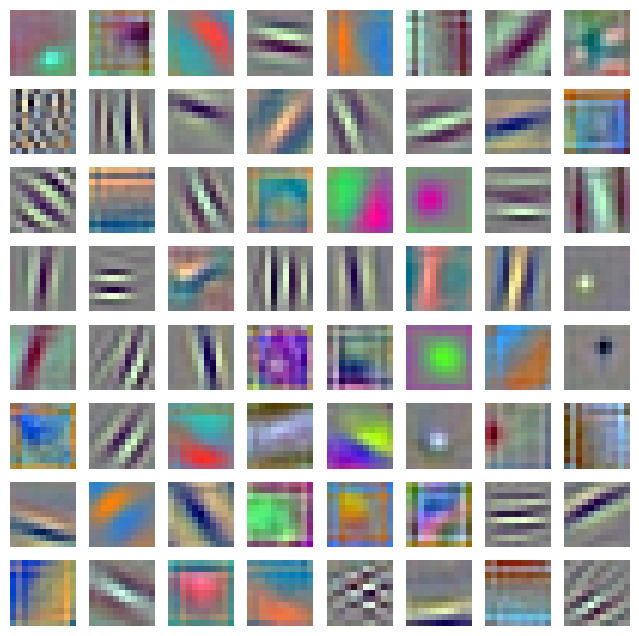

In [11]:
with torch.no_grad():
  params = list(alexnet.parameters())
  fig, axs = plt.subplots(8, 8, figsize=(8, 8))
  filters = []
  for filter_index in range(params[0].shape[0]):
    row_index = filter_index // 8
    col_index = filter_index % 8

    filter = params[0][filter_index,:,:,:]
    filter_image = filter.permute(1, 2, 0).cpu()
    scale = np.abs(filter_image).max()
    scaled_image = filter_image / (2 * scale) + 0.5
    filters.append(scaled_image.cpu())
    axs[row_index, col_index].imshow(scaled_image.cpu())
    axs[row_index, col_index].axis('off')
  plt.show()

**These remind me of the line filters we previously applied to recognize "X" and "O".**

## 2.2: ResNet

In this section we'll be working with a state of the art CNN model called ResNet. ResNet has two particularly interesting features. First, it uses skip connections to avoid the vanishing gradient problem. Second, each block (collection of layers) in a ResNet can be treated as learning a residual function.

Mathematically, a neural network can be thought of as a series of operations that maps an input (like an image of a dog) to an output (like the label "dog"). In math-speak a mapping from an input to an output is called a function. Neural networks are a flexible way of expressing that function.

If you were to subtract out the true function mapping images to class labels from the function learned by a network, you'd be left with the residual error or "residual function". ResNets try to learn the original function, then the residual function, then the residual of the residual, and so on, using their residual blocks and adding them to the output of the preceeding layers.

In this section we'll run several images through a pre-trained ResNet and see what happens.

In [12]:
# @title Download imagenette
import requests, tarfile, os

fname = 'imagenette2-320'
url = 'https://osf.io/mnve4/download'

if not os.path.exists(fname):
  print("Data is being downloaded...")
  r = requests.get(url, stream=True)
  with open(fname+'tgz', 'wb') as fd:
    fd.write(r.content)

  with tarfile.open(fname+'tgz', "r") as ft:
    ft.extractall()

  os.remove(fname+'tgz')
  print("The download has been completed.")
else:
  print("Data has already been downloaded.")

Data is being downloaded...
The download has been completed.


In [17]:
# @title Set Up Textual ImageNet labels
dict_map={0: 'tench, Tinca tinca',
 1: 'goldfish, Carassius auratus',
 2: 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias',
 3: 'tiger shark, Galeocerdo cuvieri',
 4: 'hammerhead, hammerhead shark',
 5: 'electric ray, crampfish, numbfish, torpedo',
 6: 'stingray',
 7: 'cock',
 8: 'hen',
 9: 'ostrich, Struthio camelus',
 10: 'brambling, Fringilla montifringilla',
 11: 'goldfinch, Carduelis carduelis',
 12: 'house finch, linnet, Carpodacus mexicanus',
 13: 'junco, snowbird',
 14: 'indigo bunting, indigo finch, indigo bird, Passerina cyanea',
 15: 'robin, American robin, Turdus migratorius',
 16: 'bulbul',
 17: 'jay',
 18: 'magpie',
 19: 'chickadee',
 20: 'water ouzel, dipper',
 21: 'kite',
 22: 'bald eagle, American eagle, Haliaeetus leucocephalus',
 23: 'vulture',
 24: 'great grey owl, great gray owl, Strix nebulosa',
 25: 'European fire salamander, Salamandra salamandra',
 26: 'common newt, Triturus vulgaris',
 27: 'eft',
 28: 'spotted salamander, Ambystoma maculatum',
 29: 'axolotl, mud puppy, Ambystoma mexicanum',
 30: 'bullfrog, Rana catesbeiana',
 31: 'tree frog, tree-frog',
 32: 'tailed frog, bell toad, ribbed toad, tailed toad, Ascaphus trui',
 33: 'loggerhead, loggerhead turtle, Caretta caretta',
 34: 'leatherback turtle, leatherback, leathery turtle, Dermochelys coriacea',
 35: 'mud turtle',
 36: 'terrapin',
 37: 'box turtle, box tortoise',
 38: 'banded gecko',
 39: 'common iguana, iguana, Iguana iguana',
 40: 'American chameleon, anole, Anolis carolinensis',
 41: 'whiptail, whiptail lizard',
 42: 'agama',
 43: 'frilled lizard, Chlamydosaurus kingi',
 44: 'alligator lizard',
 45: 'Gila monster, Heloderma suspectum',
 46: 'green lizard, Lacerta viridis',
 47: 'African chameleon, Chamaeleo chamaeleon',
 48: 'Komodo dragon, Komodo lizard, dragon lizard, giant lizard, Varanus komodoensis',
 49: 'African crocodile, Nile crocodile, Crocodylus niloticus',
 50: 'American alligator, Alligator mississipiensis',
 51: 'triceratops',
 52: 'thunder snake, worm snake, Carphophis amoenus',
 53: 'ringneck snake, ring-necked snake, ring snake',
 54: 'hognose snake, puff adder, sand viper',
 55: 'green snake, grass snake',
 56: 'king snake, kingsnake',
 57: 'garter snake, grass snake',
 58: 'water snake',
 59: 'vine snake',
 60: 'night snake, Hypsiglena torquata',
 61: 'boa constrictor, Constrictor constrictor',
 62: 'rock python, rock snake, Python sebae',
 63: 'Indian cobra, Naja naja',
 64: 'green mamba',
 65: 'sea snake',
 66: 'horned viper, cerastes, sand viper, horned asp, Cerastes cornutus',
 67: 'diamondback, diamondback rattlesnake, Crotalus adamanteus',
 68: 'sidewinder, horned rattlesnake, Crotalus cerastes',
 69: 'trilobite',
 70: 'harvestman, daddy longlegs, Phalangium opilio',
 71: 'scorpion',
 72: 'black and gold garden spider, Argiope aurantia',
 73: 'barn spider, Araneus cavaticus',
 74: 'garden spider, Aranea diademata',
 75: 'black widow, Latrodectus mactans',
 76: 'tarantula',
 77: 'wolf spider, hunting spider',
 78: 'tick',
 79: 'centipede',
 80: 'black grouse',
 81: 'ptarmigan',
 82: 'ruffed grouse, partridge, Bonasa umbellus',
 83: 'prairie chicken, prairie grouse, prairie fowl',
 84: 'peacock',
 85: 'quail',
 86: 'partridge',
 87: 'African grey, African gray, Psittacus erithacus',
 88: 'macaw',
 89: 'sulphur-crested cockatoo, Kakatoe galerita, Cacatua galerita',
 90: 'lorikeet',
 91: 'coucal',
 92: 'bee eater',
 93: 'hornbill',
 94: 'hummingbird',
 95: 'jacamar',
 96: 'toucan',
 97: 'drake',
 98: 'red-breasted merganser, Mergus serrator',
 99: 'goose',
 100: 'black swan, Cygnus atratus',
 101: 'tusker',
 102: 'echidna, spiny anteater, anteater',
 103: 'platypus, duckbill, duckbilled platypus, duck-billed platypus, Ornithorhynchus anatinus',
 104: 'wallaby, brush kangaroo',
 105: 'koala, koala bear, kangaroo bear, native bear, Phascolarctos cinereus',
 106: 'wombat',
 107: 'jellyfish',
 108: 'sea anemone, anemone',
 109: 'brain coral',
 110: 'flatworm, platyhelminth',
 111: 'nematode, nematode worm, roundworm',
 112: 'conch',
 113: 'snail',
 114: 'slug',
 115: 'sea slug, nudibranch',
 116: 'chiton, coat-of-mail shell, sea cradle, polyplacophore',
 117: 'chambered nautilus, pearly nautilus, nautilus',
 118: 'Dungeness crab, Cancer magister',
 119: 'rock crab, Cancer irroratus',
 120: 'fiddler crab',
 121: 'king crab, Alaska crab, Alaskan king crab, Alaska king crab, Paralithodes camtschatica',
 122: 'American lobster, Northern lobster, Maine lobster, Homarus americanus',
 123: 'spiny lobster, langouste, rock lobster, crawfish, crayfish, sea crawfish',
 124: 'crayfish, crawfish, crawdad, crawdaddy',
 125: 'hermit crab',
 126: 'isopod',
 127: 'white stork, Ciconia ciconia',
 128: 'black stork, Ciconia nigra',
 129: 'spoonbill',
 130: 'flamingo',
 131: 'little blue heron, Egretta caerulea',
 132: 'American egret, great white heron, Egretta albus',
 133: 'bittern',
 134: 'crane',
 135: 'limpkin, Aramus pictus',
 136: 'European gallinule, Porphyrio porphyrio',
 137: 'American coot, marsh hen, mud hen, water hen, Fulica americana',
 138: 'bustard',
 139: 'ruddy turnstone, Arenaria interpres',
 140: 'red-backed sandpiper, dunlin, Erolia alpina',
 141: 'redshank, Tringa totanus',
 142: 'dowitcher',
 143: 'oystercatcher, oyster catcher',
 144: 'pelican',
 145: 'king penguin, Aptenodytes patagonica',
 146: 'albatross, mollymawk',
 147: 'grey whale, gray whale, devilfish, Eschrichtius gibbosus, Eschrichtius robustus',
 148: 'killer whale, killer, orca, grampus, sea wolf, Orcinus orca',
 149: 'dugong, Dugong dugon',
 150: 'sea lion',
 151: 'Chihuahua',
 152: 'Japanese spaniel',
 153: 'Maltese dog, Maltese terrier, Maltese',
 154: 'Pekinese, Pekingese, Peke',
 155: 'Shih-Tzu',
 156: 'Blenheim spaniel',
 157: 'papillon',
 158: 'toy terrier',
 159: 'Rhodesian ridgeback',
 160: 'Afghan hound, Afghan',
 161: 'basset, basset hound',
 162: 'beagle',
 163: 'bloodhound, sleuthhound',
 164: 'bluetick',
 165: 'black-and-tan coonhound',
 166: 'Walker hound, Walker foxhound',
 167: 'English foxhound',
 168: 'redbone',
 169: 'borzoi, Russian wolfhound',
 170: 'Irish wolfhound',
 171: 'Italian greyhound',
 172: 'whippet',
 173: 'Ibizan hound, Ibizan Podenco',
 174: 'Norwegian elkhound, elkhound',
 175: 'otterhound, otter hound',
 176: 'Saluki, gazelle hound',
 177: 'Scottish deerhound, deerhound',
 178: 'Weimaraner',
 179: 'Staffordshire bullterrier, Staffordshire bull terrier',
 180: 'American Staffordshire terrier, Staffordshire terrier, American pit bull terrier, pit bull terrier',
 181: 'Bedlington terrier',
 182: 'Border terrier',
 183: 'Kerry blue terrier',
 184: 'Irish terrier',
 185: 'Norfolk terrier',
 186: 'Norwich terrier',
 187: 'Yorkshire terrier',
 188: 'wire-haired fox terrier',
 189: 'Lakeland terrier',
 190: 'Sealyham terrier, Sealyham',
 191: 'Airedale, Airedale terrier',
 192: 'cairn, cairn terrier',
 193: 'Australian terrier',
 194: 'Dandie Dinmont, Dandie Dinmont terrier',
 195: 'Boston bull, Boston terrier',
 196: 'miniature schnauzer',
 197: 'giant schnauzer',
 198: 'standard schnauzer',
 199: 'Scotch terrier, Scottish terrier, Scottie',
 200: 'Tibetan terrier, chrysanthemum dog',
 201: 'silky terrier, Sydney silky',
 202: 'soft-coated wheaten terrier',
 203: 'West Highland white terrier',
 204: 'Lhasa, Lhasa apso',
 205: 'flat-coated retriever',
 206: 'curly-coated retriever',
 207: 'golden retriever',
 208: 'Labrador retriever',
 209: 'Chesapeake Bay retriever',
 210: 'German short-haired pointer',
 211: 'vizsla, Hungarian pointer',
 212: 'English setter',
 213: 'Irish setter, red setter',
 214: 'Gordon setter',
 215: 'Brittany spaniel',
 216: 'clumber, clumber spaniel',
 217: 'English springer, English springer spaniel',
 218: 'Welsh springer spaniel',
 219: 'cocker spaniel, English cocker spaniel, cocker',
 220: 'Sussex spaniel',
 221: 'Irish water spaniel',
 222: 'kuvasz',
 223: 'schipperke',
 224: 'groenendael',
 225: 'malinois',
 226: 'briard',
 227: 'kelpie',
 228: 'komondor',
 229: 'Old English sheepdog, bobtail',
 230: 'Shetland sheepdog, Shetland sheep dog, Shetland',
 231: 'collie',
 232: 'Border collie',
 233: 'Bouvier des Flandres, Bouviers des Flandres',
 234: 'Rottweiler',
 235: 'German shepherd, German shepherd dog, German police dog, alsatian',
 236: 'Doberman, Doberman pinscher',
 237: 'miniature pinscher',
 238: 'Greater Swiss Mountain dog',
 239: 'Bernese mountain dog',
 240: 'Appenzeller',
 241: 'EntleBucher',
 242: 'boxer',
 243: 'bull mastiff',
 244: 'Tibetan mastiff',
 245: 'French bulldog',
 246: 'Great Dane',
 247: 'Saint Bernard, St Bernard',
 248: 'Eskimo dog, husky',
 249: 'malamute, malemute, Alaskan malamute',
 250: 'Siberian husky',
 251: 'dalmatian, coach dog, carriage dog',
 252: 'affenpinscher, monkey pinscher, monkey dog',
 253: 'basenji',
 254: 'pug, pug-dog',
 255: 'Leonberg',
 256: 'Newfoundland, Newfoundland dog',
 257: 'Great Pyrenees',
 258: 'Samoyed, Samoyede',
 259: 'Pomeranian',
 260: 'chow, chow chow',
 261: 'keeshond',
 262: 'Brabancon griffon',
 263: 'Pembroke, Pembroke Welsh corgi',
 264: 'Cardigan, Cardigan Welsh corgi',
 265: 'toy poodle',
 266: 'miniature poodle',
 267: 'standard poodle',
 268: 'Mexican hairless',
 269: 'timber wolf, grey wolf, gray wolf, Canis lupus',
 270: 'white wolf, Arctic wolf, Canis lupus tundrarum',
 271: 'red wolf, maned wolf, Canis rufus, Canis niger',
 272: 'coyote, prairie wolf, brush wolf, Canis latrans',
 273: 'dingo, warrigal, warragal, Canis dingo',
 274: 'dhole, Cuon alpinus',
 275: 'African hunting dog, hyena dog, Cape hunting dog, Lycaon pictus',
 276: 'hyena, hyaena',
 277: 'red fox, Vulpes vulpes',
 278: 'kit fox, Vulpes macrotis',
 279: 'Arctic fox, white fox, Alopex lagopus',
 280: 'grey fox, gray fox, Urocyon cinereoargenteus',
 281: 'tabby, tabby cat',
 282: 'tiger cat',
 283: 'Persian cat',
 284: 'Siamese cat, Siamese',
 285: 'Egyptian cat',
 286: 'cougar, puma, catamount, mountain lion, painter, panther, Felis concolor',
 287: 'lynx, catamount',
 288: 'leopard, Panthera pardus',
 289: 'snow leopard, ounce, Panthera uncia',
 290: 'jaguar, panther, Panthera onca, Felis onca',
 291: 'lion, king of beasts, Panthera leo',
 292: 'tiger, Panthera tigris',
 293: 'cheetah, chetah, Acinonyx jubatus',
 294: 'brown bear, bruin, Ursus arctos',
 295: 'American black bear, black bear, Ursus americanus, Euarctos americanus',
 296: 'ice bear, polar bear, Ursus Maritimus, Thalarctos maritimus',
 297: 'sloth bear, Melursus ursinus, Ursus ursinus',
 298: 'mongoose',
 299: 'meerkat, mierkat',
 300: 'tiger beetle',
 301: 'ladybug, ladybeetle, lady beetle, ladybird, ladybird beetle',
 302: 'ground beetle, carabid beetle',
 303: 'long-horned beetle, longicorn, longicorn beetle',
 304: 'leaf beetle, chrysomelid',
 305: 'dung beetle',
 306: 'rhinoceros beetle',
 307: 'weevil',
 308: 'fly',
 309: 'bee',
 310: 'ant, emmet, pismire',
 311: 'grasshopper, hopper',
 312: 'cricket',
 313: 'walking stick, walkingstick, stick insect',
 314: 'cockroach, roach',
 315: 'mantis, mantid',
 316: 'cicada, cicala',
 317: 'leafhopper',
 318: 'lacewing, lacewing fly',
 319: "dragonfly, darning needle, devil's darning needle, sewing needle, snake feeder, snake doctor, mosquito hawk, skeeter hawk",
 320: 'damselfly',
 321: 'admiral',
 322: 'ringlet, ringlet butterfly',
 323: 'monarch, monarch butterfly, milkweed butterfly, Danaus plexippus',
 324: 'cabbage butterfly',
 325: 'sulphur butterfly, sulfur butterfly',
 326: 'lycaenid, lycaenid butterfly',
 327: 'starfish, sea star',
 328: 'sea urchin',
 329: 'sea cucumber, holothurian',
 330: 'wood rabbit, cottontail, cottontail rabbit',
 331: 'hare',
 332: 'Angora, Angora rabbit',
 333: 'hamster',
 334: 'porcupine, hedgehog',
 335: 'fox squirrel, eastern fox squirrel, Sciurus niger',
 336: 'marmot',
 337: 'beaver',
 338: 'guinea pig, Cavia cobaya',
 339: 'sorrel',
 340: 'zebra',
 341: 'hog, pig, grunter, squealer, Sus scrofa',
 342: 'wild boar, boar, Sus scrofa',
 343: 'warthog',
 344: 'hippopotamus, hippo, river horse, Hippopotamus amphibius',
 345: 'ox',
 346: 'water buffalo, water ox, Asiatic buffalo, Bubalus bubalis',
 347: 'bison',
 348: 'ram, tup',
 349: 'bighorn, bighorn sheep, cimarron, Rocky Mountain bighorn, Rocky Mountain sheep, Ovis canadensis',
 350: 'ibex, Capra ibex',
 351: 'hartebeest',
 352: 'impala, Aepyceros melampus',
 353: 'gazelle',
 354: 'Arabian camel, dromedary, Camelus dromedarius',
 355: 'llama',
 356: 'weasel',
 357: 'mink',
 358: 'polecat, fitch, foulmart, foumart, Mustela putorius',
 359: 'black-footed ferret, ferret, Mustela nigripes',
 360: 'otter',
 361: 'skunk, polecat, wood pussy',
 362: 'badger',
 363: 'armadillo',
 364: 'three-toed sloth, ai, Bradypus tridactylus',
 365: 'orangutan, orang, orangutang, Pongo pygmaeus',
 366: 'gorilla, Gorilla gorilla',
 367: 'chimpanzee, chimp, Pan troglodytes',
 368: 'gibbon, Hylobates lar',
 369: 'siamang, Hylobates syndactylus, Symphalangus syndactylus',
 370: 'guenon, guenon monkey',
 371: 'patas, hussar monkey, Erythrocebus patas',
 372: 'baboon',
 373: 'macaque',
 374: 'langur',
 375: 'colobus, colobus monkey',
 376: 'proboscis monkey, Nasalis larvatus',
 377: 'marmoset',
 378: 'capuchin, ringtail, Cebus capucinus',
 379: 'howler monkey, howler',
 380: 'titi, titi monkey',
 381: 'spider monkey, Ateles geoffroyi',
 382: 'squirrel monkey, Saimiri sciureus',
 383: 'Madagascar cat, ring-tailed lemur, Lemur catta',
 384: 'indri, indris, Indri indri, Indri brevicaudatus',
 385: 'Indian elephant, Elephas maximus',
 386: 'African elephant, Loxodonta africana',
 387: 'lesser panda, red panda, panda, bear cat, cat bear, Ailurus fulgens',
 388: 'giant panda, panda, panda bear, coon bear, Ailuropoda melanoleuca',
 389: 'barracouta, snoek',
 390: 'eel',
 391: 'coho, cohoe, coho salmon, blue jack, silver salmon, Oncorhynchus kisutch',
 392: 'rock beauty, Holocanthus tricolor',
 393: 'anemone fish',
 394: 'sturgeon',
 395: 'gar, garfish, garpike, billfish, Lepisosteus osseus',
 396: 'lionfish',
 397: 'puffer, pufferfish, blowfish, globefish',
 398: 'abacus',
 399: 'abaya',
 400: "academic gown, academic robe, judge's robe",
 401: 'accordion, piano accordion, squeeze box',
 402: 'acoustic guitar',
 403: 'aircraft carrier, carrier, flattop, attack aircraft carrier',
 404: 'airliner',
 405: 'airship, dirigible',
 406: 'altar',
 407: 'ambulance',
 408: 'amphibian, amphibious vehicle',
 409: 'analog clock',
 410: 'apiary, bee house',
 411: 'apron',
 412: 'ashcan, trash can, garbage can, wastebin, ash bin, ash-bin, ashbin, dustbin, trash barrel, trash bin',
 413: 'assault rifle, assault gun',
 414: 'backpack, back pack, knapsack, packsack, rucksack, haversack',
 415: 'bakery, bakeshop, bakehouse',
 416: 'balance beam, beam',
 417: 'balloon',
 418: 'ballpoint, ballpoint pen, ballpen, Biro',
 419: 'Band Aid',
 420: 'banjo',
 421: 'bannister, banister, balustrade, balusters, handrail',
 422: 'barbell',
 423: 'barber chair',
 424: 'barbershop',
 425: 'barn',
 426: 'barometer',
 427: 'barrel, cask',
 428: 'barrow, garden cart, lawn cart, wheelbarrow',
 429: 'baseball',
 430: 'basketball',
 431: 'bassinet',
 432: 'bassoon',
 433: 'bathing cap, swimming cap',
 434: 'bath towel',
 435: 'bathtub, bathing tub, bath, tub',
 436: 'beach wagon, station wagon, wagon, estate car, beach waggon, station waggon, waggon',
 437: 'beacon, lighthouse, beacon light, pharos',
 438: 'beaker',
 439: 'bearskin, busby, shako',
 440: 'beer bottle',
 441: 'beer glass',
 442: 'bell cote, bell cot',
 443: 'bib',
 444: 'bicycle-built-for-two, tandem bicycle, tandem',
 445: 'bikini, two-piece',
 446: 'binder, ring-binder',
 447: 'binoculars, field glasses, opera glasses',
 448: 'birdhouse',
 449: 'boathouse',
 450: 'bobsled, bobsleigh, bob',
 451: 'bolo tie, bolo, bola tie, bola',
 452: 'bonnet, poke bonnet',
 453: 'bookcase',
 454: 'bookshop, bookstore, bookstall',
 455: 'bottlecap',
 456: 'bow',
 457: 'bow tie, bow-tie, bowtie',
 458: 'brass, memorial tablet, plaque',
 459: 'brassiere, bra, bandeau',
 460: 'breakwater, groin, groyne, mole, bulwark, seawall, jetty',
 461: 'breastplate, aegis, egis',
 462: 'broom',
 463: 'bucket, pail',
 464: 'buckle',
 465: 'bulletproof vest',
 466: 'bullet train, bullet',
 467: 'butcher shop, meat market',
 468: 'cab, hack, taxi, taxicab',
 469: 'caldron, cauldron',
 470: 'candle, taper, wax light',
 471: 'cannon',
 472: 'canoe',
 473: 'can opener, tin opener',
 474: 'cardigan',
 475: 'car mirror',
 476: 'carousel, carrousel, merry-go-round, roundabout, whirligig',
 477: "carpenter's kit, tool kit",
 478: 'carton',
 479: 'car wheel',
 480: 'cash machine, cash dispenser, automated teller machine, automatic teller machine, automated teller, automatic teller, ATM',
 481: 'cassette',
 482: 'cassette player',
 483: 'castle',
 484: 'catamaran',
 485: 'CD player',
 486: 'cello, violoncello',
 487: 'cellular telephone, cellular phone, cellphone, cell, mobile phone',
 488: 'chain',
 489: 'chainlink fence',
 490: 'chain mail, ring mail, mail, chain armor, chain armour, ring armor, ring armour',
 491: 'chain saw, chainsaw',
 492: 'chest',
 493: 'chiffonier, commode',
 494: 'chime, bell, gong',
 495: 'china cabinet, china closet',
 496: 'Christmas stocking',
 497: 'church, church building',
 498: 'cinema, movie theater, movie theatre, movie house, picture palace',
 499: 'cleaver, meat cleaver, chopper',
 500: 'cliff dwelling',
 501: 'cloak',
 502: 'clog, geta, patten, sabot',
 503: 'cocktail shaker',
 504: 'coffee mug',
 505: 'coffeepot',
 506: 'coil, spiral, volute, whorl, helix',
 507: 'combination lock',
 508: 'computer keyboard, keypad',
 509: 'confectionery, confectionary, candy store',
 510: 'container ship, containership, container vessel',
 511: 'convertible',
 512: 'corkscrew, bottle screw',
 513: 'cornet, horn, trumpet, trump',
 514: 'cowboy boot',
 515: 'cowboy hat, ten-gallon hat',
 516: 'cradle',
 517: 'crane',
 518: 'crash helmet',
 519: 'crate',
 520: 'crib, cot',
 521: 'Crock Pot',
 522: 'croquet ball',
 523: 'crutch',
 524: 'cuirass',
 525: 'dam, dike, dyke',
 526: 'desk',
 527: 'desktop computer',
 528: 'dial telephone, dial phone',
 529: 'diaper, nappy, napkin',
 530: 'digital clock',
 531: 'digital watch',
 532: 'dining table, board',
 533: 'dishrag, dishcloth',
 534: 'dishwasher, dish washer, dishwashing machine',
 535: 'disk brake, disc brake',
 536: 'dock, dockage, docking facility',
 537: 'dogsled, dog sled, dog sleigh',
 538: 'dome',
 539: 'doormat, welcome mat',
 540: 'drilling platform, offshore rig',
 541: 'drum, membranophone, tympan',
 542: 'drumstick',
 543: 'dumbbell',
 544: 'Dutch oven',
 545: 'electric fan, blower',
 546: 'electric guitar',
 547: 'electric locomotive',
 548: 'entertainment center',
 549: 'envelope',
 550: 'espresso maker',
 551: 'face powder',
 552: 'feather boa, boa',
 553: 'file, file cabinet, filing cabinet',
 554: 'fireboat',
 555: 'fire engine, fire truck',
 556: 'fire screen, fireguard',
 557: 'flagpole, flagstaff',
 558: 'flute, transverse flute',
 559: 'folding chair',
 560: 'football helmet',
 561: 'forklift',
 562: 'fountain',
 563: 'fountain pen',
 564: 'four-poster',
 565: 'freight car',
 566: 'French horn, horn',
 567: 'frying pan, frypan, skillet',
 568: 'fur coat',
 569: 'garbage truck, dustcart',
 570: 'gasmask, respirator, gas helmet',
 571: 'gas pump, gasoline pump, petrol pump, island dispenser',
 572: 'goblet',
 573: 'go-kart',
 574: 'golf ball',
 575: 'golfcart, golf cart',
 576: 'gondola',
 577: 'gong, tam-tam',
 578: 'gown',
 579: 'grand piano, grand',
 580: 'greenhouse, nursery, glasshouse',
 581: 'grille, radiator grille',
 582: 'grocery store, grocery, food market, market',
 583: 'guillotine',
 584: 'hair slide',
 585: 'hair spray',
 586: 'half track',
 587: 'hammer',
 588: 'hamper',
 589: 'hand blower, blow dryer, blow drier, hair dryer, hair drier',
 590: 'hand-held computer, hand-held microcomputer',
 591: 'handkerchief, hankie, hanky, hankey',
 592: 'hard disc, hard disk, fixed disk',
 593: 'harmonica, mouth organ, harp, mouth harp',
 594: 'harp',
 595: 'harvester, reaper',
 596: 'hatchet',
 597: 'holster',
 598: 'home theater, home theatre',
 599: 'honeycomb',
 600: 'hook, claw',
 601: 'hoopskirt, crinoline',
 602: 'horizontal bar, high bar',
 603: 'horse cart, horse-cart',
 604: 'hourglass',
 605: 'iPod',
 606: 'iron, smoothing iron',
 607: "jack-o'-lantern",
 608: 'jean, blue jean, denim',
 609: 'jeep, landrover',
 610: 'jersey, T-shirt, tee shirt',
 611: 'jigsaw puzzle',
 612: 'jinrikisha, ricksha, rickshaw',
 613: 'joystick',
 614: 'kimono',
 615: 'knee pad',
 616: 'knot',
 617: 'lab coat, laboratory coat',
 618: 'ladle',
 619: 'lampshade, lamp shade',
 620: 'laptop, laptop computer',
 621: 'lawn mower, mower',
 622: 'lens cap, lens cover',
 623: 'letter opener, paper knife, paperknife',
 624: 'library',
 625: 'lifeboat',
 626: 'lighter, light, igniter, ignitor',
 627: 'limousine, limo',
 628: 'liner, ocean liner',
 629: 'lipstick, lip rouge',
 630: 'Loafer',
 631: 'lotion',
 632: 'loudspeaker, speaker, speaker unit, loudspeaker system, speaker system',
 633: "loupe, jeweler's loupe",
 634: 'lumbermill, sawmill',
 635: 'magnetic compass',
 636: 'mailbag, postbag',
 637: 'mailbox, letter box',
 638: 'maillot',
 639: 'maillot, tank suit',
 640: 'manhole cover',
 641: 'maraca',
 642: 'marimba, xylophone',
 643: 'mask',
 644: 'matchstick',
 645: 'maypole',
 646: 'maze, labyrinth',
 647: 'measuring cup',
 648: 'medicine chest, medicine cabinet',
 649: 'megalith, megalithic structure',
 650: 'microphone, mike',
 651: 'microwave, microwave oven',
 652: 'military uniform',
 653: 'milk can',
 654: 'minibus',
 655: 'miniskirt, mini',
 656: 'minivan',
 657: 'missile',
 658: 'mitten',
 659: 'mixing bowl',
 660: 'mobile home, manufactured home',
 661: 'Model T',
 662: 'modem',
 663: 'monastery',
 664: 'monitor',
 665: 'moped',
 666: 'mortar',
 667: 'mortarboard',
 668: 'mosque',
 669: 'mosquito net',
 670: 'motor scooter, scooter',
 671: 'mountain bike, all-terrain bike, off-roader',
 672: 'mountain tent',
 673: 'mouse, computer mouse',
 674: 'mousetrap',
 675: 'moving van',
 676: 'muzzle',
 677: 'nail',
 678: 'neck brace',
 679: 'necklace',
 680: 'nipple',
 681: 'notebook, notebook computer',
 682: 'obelisk',
 683: 'oboe, hautboy, hautbois',
 684: 'ocarina, sweet potato',
 685: 'odometer, hodometer, mileometer, milometer',
 686: 'oil filter',
 687: 'organ, pipe organ',
 688: 'oscilloscope, scope, cathode-ray oscilloscope, CRO',
 689: 'overskirt',
 690: 'oxcart',
 691: 'oxygen mask',
 692: 'packet',
 693: 'paddle, boat paddle',
 694: 'paddlewheel, paddle wheel',
 695: 'padlock',
 696: 'paintbrush',
 697: "pajama, pyjama, pj's, jammies",
 698: 'palace',
 699: 'panpipe, pandean pipe, syrinx',
 700: 'paper towel',
 701: 'parachute, chute',
 702: 'parallel bars, bars',
 703: 'park bench',
 704: 'parking meter',
 705: 'passenger car, coach, carriage',
 706: 'patio, terrace',
 707: 'pay-phone, pay-station',
 708: 'pedestal, plinth, footstall',
 709: 'pencil box, pencil case',
 710: 'pencil sharpener',
 711: 'perfume, essence',
 712: 'Petri dish',
 713: 'photocopier',
 714: 'pick, plectrum, plectron',
 715: 'pickelhaube',
 716: 'picket fence, paling',
 717: 'pickup, pickup truck',
 718: 'pier',
 719: 'piggy bank, penny bank',
 720: 'pill bottle',
 721: 'pillow',
 722: 'ping-pong ball',
 723: 'pinwheel',
 724: 'pirate, pirate ship',
 725: 'pitcher, ewer',
 726: "plane, carpenter's plane, woodworking plane",
 727: 'planetarium',
 728: 'plastic bag',
 729: 'plate rack',
 730: 'plow, plough',
 731: "plunger, plumber's helper",
 732: 'Polaroid camera, Polaroid Land camera',
 733: 'pole',
 734: 'police van, police wagon, paddy wagon, patrol wagon, wagon, black Maria',
 735: 'poncho',
 736: 'pool table, billiard table, snooker table',
 737: 'pop bottle, soda bottle',
 738: 'pot, flowerpot',
 739: "potter's wheel",
 740: 'power drill',
 741: 'prayer rug, prayer mat',
 742: 'printer',
 743: 'prison, prison house',
 744: 'projectile, missile',
 745: 'projector',
 746: 'puck, hockey puck',
 747: 'punching bag, punch bag, punching ball, punchball',
 748: 'purse',
 749: 'quill, quill pen',
 750: 'quilt, comforter, comfort, puff',
 751: 'racer, race car, racing car',
 752: 'racket, racquet',
 753: 'radiator',
 754: 'radio, wireless',
 755: 'radio telescope, radio reflector',
 756: 'rain barrel',
 757: 'recreational vehicle, RV, R.V.',
 758: 'reel',
 759: 'reflex camera',
 760: 'refrigerator, icebox',
 761: 'remote control, remote',
 762: 'restaurant, eating house, eating place, eatery',
 763: 'revolver, six-gun, six-shooter',
 764: 'rifle',
 765: 'rocking chair, rocker',
 766: 'rotisserie',
 767: 'rubber eraser, rubber, pencil eraser',
 768: 'rugby ball',
 769: 'rule, ruler',
 770: 'running shoe',
 771: 'safe',
 772: 'safety pin',
 773: 'saltshaker, salt shaker',
 774: 'sandal',
 775: 'sarong',
 776: 'sax, saxophone',
 777: 'scabbard',
 778: 'scale, weighing machine',
 779: 'school bus',
 780: 'schooner',
 781: 'scoreboard',
 782: 'screen, CRT screen',
 783: 'screw',
 784: 'screwdriver',
 785: 'seat belt, seatbelt',
 786: 'sewing machine',
 787: 'shield, buckler',
 788: 'shoe shop, shoe-shop, shoe store',
 789: 'shoji',
 790: 'shopping basket',
 791: 'shopping cart',
 792: 'shovel',
 793: 'shower cap',
 794: 'shower curtain',
 795: 'ski',
 796: 'ski mask',
 797: 'sleeping bag',
 798: 'slide rule, slipstick',
 799: 'sliding door',
 800: 'slot, one-armed bandit',
 801: 'snorkel',
 802: 'snowmobile',
 803: 'snowplow, snowplough',
 804: 'soap dispenser',
 805: 'soccer ball',
 806: 'sock',
 807: 'solar dish, solar collector, solar furnace',
 808: 'sombrero',
 809: 'soup bowl',
 810: 'space bar',
 811: 'space heater',
 812: 'space shuttle',
 813: 'spatula',
 814: 'speedboat',
 815: "spider web, spider's web",
 816: 'spindle',
 817: 'sports car, sport car',
 818: 'spotlight, spot',
 819: 'stage',
 820: 'steam locomotive',
 821: 'steel arch bridge',
 822: 'steel drum',
 823: 'stethoscope',
 824: 'stole',
 825: 'stone wall',
 826: 'stopwatch, stop watch',
 827: 'stove',
 828: 'strainer',
 829: 'streetcar, tram, tramcar, trolley, trolley car',
 830: 'stretcher',
 831: 'studio couch, day bed',
 832: 'stupa, tope',
 833: 'submarine, pigboat, sub, U-boat',
 834: 'suit, suit of clothes',
 835: 'sundial',
 836: 'sunglass',
 837: 'sunglasses, dark glasses, shades',
 838: 'sunscreen, sunblock, sun blocker',
 839: 'suspension bridge',
 840: 'swab, swob, mop',
 841: 'sweatshirt',
 842: 'swimming trunks, bathing trunks',
 843: 'swing',
 844: 'switch, electric switch, electrical switch',
 845: 'syringe',
 846: 'table lamp',
 847: 'tank, army tank, armored combat vehicle, armoured combat vehicle',
 848: 'tape player',
 849: 'teapot',
 850: 'teddy, teddy bear',
 851: 'television, television system',
 852: 'tennis ball',
 853: 'thatch, thatched roof',
 854: 'theater curtain, theatre curtain',
 855: 'thimble',
 856: 'thresher, thrasher, threshing machine',
 857: 'throne',
 858: 'tile roof',
 859: 'toaster',
 860: 'tobacco shop, tobacconist shop, tobacconist',
 861: 'toilet seat',
 862: 'torch',
 863: 'totem pole',
 864: 'tow truck, tow car, wrecker',
 865: 'toyshop',
 866: 'tractor',
 867: 'trailer truck, tractor trailer, trucking rig, rig, articulated lorry, semi',
 868: 'tray',
 869: 'trench coat',
 870: 'tricycle, trike, velocipede',
 871: 'trimaran',
 872: 'tripod',
 873: 'triumphal arch',
 874: 'trolleybus, trolley coach, trackless trolley',
 875: 'trombone',
 876: 'tub, vat',
 877: 'turnstile',
 878: 'typewriter keyboard',
 879: 'umbrella',
 880: 'unicycle, monocycle',
 881: 'upright, upright piano',
 882: 'vacuum, vacuum cleaner',
 883: 'vase',
 884: 'vault',
 885: 'velvet',
 886: 'vending machine',
 887: 'vestment',
 888: 'viaduct',
 889: 'violin, fiddle',
 890: 'volleyball',
 891: 'waffle iron',
 892: 'wall clock',
 893: 'wallet, billfold, notecase, pocketbook',
 894: 'wardrobe, closet, press',
 895: 'warplane, military plane',
 896: 'washbasin, handbasin, washbowl, lavabo, wash-hand basin',
 897: 'washer, automatic washer, washing machine',
 898: 'water bottle',
 899: 'water jug',
 900: 'water tower',
 901: 'whiskey jug',
 902: 'whistle',
 903: 'wig',
 904: 'window screen',
 905: 'window shade',
 906: 'Windsor tie',
 907: 'wine bottle',
 908: 'wing',
 909: 'wok',
 910: 'wooden spoon',
 911: 'wool, woolen, woollen',
 912: 'worm fence, snake fence, snake-rail fence, Virginia fence',
 913: 'wreck',
 914: 'yawl',
 915: 'yurt',
 916: 'web site, website, internet site, site',
 917: 'comic book',
 918: 'crossword puzzle, crossword',
 919: 'street sign',
 920: 'traffic light, traffic signal, stoplight',
 921: 'book jacket, dust cover, dust jacket, dust wrapper',
 922: 'menu',
 923: 'plate',
 924: 'guacamole',
 925: 'consomme',
 926: 'hot pot, hotpot',
 927: 'trifle',
 928: 'ice cream, icecream',
 929: 'ice lolly, lolly, lollipop, popsicle',
 930: 'French loaf',
 931: 'bagel, beigel',
 932: 'pretzel',
 933: 'cheeseburger',
 934: 'hotdog, hot dog, red hot',
 935: 'mashed potato',
 936: 'head cabbage',
 937: 'broccoli',
 938: 'cauliflower',
 939: 'zucchini, courgette',
 940: 'spaghetti squash',
 941: 'acorn squash',
 942: 'butternut squash',
 943: 'cucumber, cuke',
 944: 'artichoke, globe artichoke',
 945: 'bell pepper',
 946: 'cardoon',
 947: 'mushroom',
 948: 'Granny Smith',
 949: 'strawberry',
 950: 'orange',
 951: 'lemon',
 952: 'fig',
 953: 'pineapple, ananas',
 954: 'banana',
 955: 'jackfruit, jak, jack',
 956: 'custard apple',
 957: 'pomegranate',
 958: 'hay',
 959: 'carbonara',
 960: 'chocolate sauce, chocolate syrup',
 961: 'dough',
 962: 'meat loaf, meatloaf',
 963: 'pizza, pizza pie',
 964: 'potpie',
 965: 'burrito',
 966: 'red wine',
 967: 'espresso',
 968: 'cup',
 969: 'eggnog',
 970: 'alp',
 971: 'bubble',
 972: 'cliff, drop, drop-off',
 973: 'coral reef',
 974: 'geyser',
 975: 'lakeside, lakeshore',
 976: 'promontory, headland, head, foreland',
 977: 'sandbar, sand bar',
 978: 'seashore, coast, seacoast, sea-coast',
 979: 'valley, vale',
 980: 'volcano',
 981: 'ballplayer, baseball player',
 982: 'groom, bridegroom',
 983: 'scuba diver',
 984: 'rapeseed',
 985: 'daisy',
 986: "yellow lady's slipper, yellow lady-slipper, Cypripedium calceolus, Cypripedium parviflorum",
 987: 'corn',
 988: 'acorn',
 989: 'hip, rose hip, rosehip',
 990: 'buckeye, horse chestnut, conker',
 991: 'coral fungus',
 992: 'agaric',
 993: 'gyromitra',
 994: 'stinkhorn, carrion fungus',
 995: 'earthstar',
 996: 'hen-of-the-woods, hen of the woods, Polyporus frondosus, Grifola frondosa',
 997: 'bolete',
 998: 'ear, spike, capitulum',
 999: 'toilet tissue, toilet paper, bathroom tissue'}

In [18]:
# @title Map Imagenette Labels to Imagenet Labels
dir_to_imagenet_index = {
    'n03888257': 1,
    'n03425413': 571,
    'n03394916': 566,
    'n03000684': 491,
    'n02102040': 217,
    'n03445777': 574,
    'n03417042': 569,
    'n03028079': 497,
    'n02979186': 482,
    'n01440764': 701
    }

dir_index_to_imagenet_label = {}
ordered_dirs = sorted(list(dir_to_imagenet_index.keys()))

for dir_index, dir_name in enumerate(ordered_dirs):
  dir_index_to_imagenet_label[dir_index] = dir_to_imagenet_index[dir_name]

In [19]:
# @title Prepare Imagenette Data
val_transform = transforms.Compose((transforms.Resize((256, 256)),
                                    transforms.ToTensor()))

imagenette_val = ImageFolder('imagenette2-320/val', transform=val_transform)

train_transform = transforms.Compose((transforms.Resize((256, 256)),
                                      transforms.ToTensor()))

imagenette_train = ImageFolder('imagenette2-320/train',
                               transform=train_transform)
random.seed(SEED)
random_indices = random.sample(range(len(imagenette_train)), 400)
imagenette_train_subset = torch.utils.data.Subset(imagenette_train,
                                                  random_indices)




# Subset to only one tenth of the data for faster runtime
random_indices = random.sample(range(len(imagenette_val)), int(len(imagenette_val) * .1))
imagenette_val = torch.utils.data.Subset(imagenette_val, random_indices)

Let's visualize a few images in our dataset.

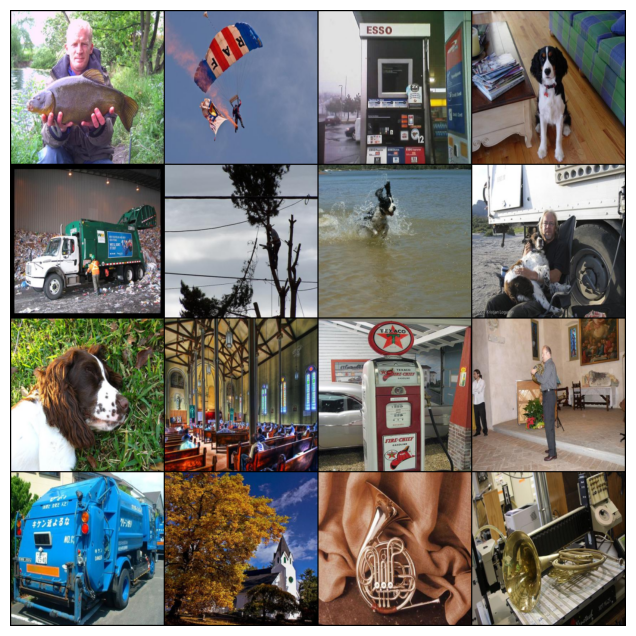

In [20]:
# To preserve reproducibility
g_seed = torch.Generator()
g_seed.manual_seed(SEED)

imagenette_train_loader = torch.utils.data.DataLoader(imagenette_train_subset,
                                                      batch_size=16,
                                                      shuffle=True,
                                                      num_workers=2,
                                                      worker_init_fn=seed_worker,
                                                      generator=g_seed
                                                      )

imagenette_val_loader = torch.utils.data.DataLoader(imagenette_val,
                                                    batch_size=16,
                                                    shuffle=False,
                                                    num_workers=2,
                                                    worker_init_fn=seed_worker,
                                                    generator=g_seed)

dataiter = iter(imagenette_val_loader)
images, labels = next(dataiter)

# Show images
plt.figure(figsize=(8, 8))
plt.imshow(make_grid(images, nrow=4).permute(1, 2, 0))
plt.axis('off')
plt.show()

In [21]:
# @title eval_imagenette function
def eval_imagenette(resnet, data_loader, dataset_length, device):
  resnet.eval()
  with torch.no_grad():
    loss_sum = 0
    total_1_correct = 0
    total_5_correct = 0
    total = dataset_length
    for batch in tqdm.tqdm(data_loader):
      images, labels = batch

      # Map the imagenette labels onto the network's output
      for i, label in enumerate(labels):
          labels[i] = dir_index_to_imagenet_label[label.item()]

      images = images.to(device)
      labels = labels.to(device)
      output = resnet(images)

      # Calculate top-5 accuracy
      # Implementation from https://github.com/bearpaw/pytorch-classification/blob/cc9106d598ff1fe375cc030873ceacfea0499d77/utils/eval.py
      batch_size = labels.size(0)

      _, predictions = output.topk(5, 1, True, True)
      predictions = predictions.t()

      top_k_correct = predictions.eq(labels.view(1, -1).expand_as(predictions))
      top_k_correct = top_k_correct.sum()

      predictions = torch.argmax(output, dim=1)
      top_1_correct = torch.sum(predictions == labels)
      total_1_correct += top_1_correct
      total_5_correct += top_k_correct

    top_1_acc = total_1_correct / total
    top_5_acc = total_5_correct / total

    return top_1_acc, top_5_acc

In [22]:
# @title Imagenette Train Loop

def imagenette_train_loop(model, optimizer, train_loader,
                          loss_fn, device):
  """
  Training loop for Imagenette

  Args:
    model: nn.module
      Untrained model
    optimizer: function
      Optimizer
    train_loader: torch.loader
      Training loader
    loss_fn: function
      Criterion
    device: string
      If available, GPU/CUDA. CPU otherwise

  Returns:
    model: nn.module
      Trained model
  """
  for epoch in tqdm.tqdm(range(5)):
    # Set model to use the imagenette classifier head
    model.train()
    # Train on a batch of images
    for imagenette_batch in train_loader:
      images, labels = imagenette_batch

      # Convert labels from imagenette indices to imagenet labels
      for i, label in enumerate(labels):
        labels[i] = dir_index_to_imagenet_label[label.item()]

      images = images.to(device)
      labels = labels.to(device)
      output = model(images)
      optimizer.zero_grad()
      loss = loss_fn(output, labels)
      loss.backward()
      optimizer.step()

  return model

The following cell creates a ResNet model pretrained on the 1000-class version of ImageNet. The model is then trained to make predictions on Imagenette, a small subset of ImageNet classes that is useful for demonstrations and prototyping. If you are not on a GPU runtime it will be extraordinarily slow!

In [43]:
# Original network
top_1_accuracies = []
top_5_accuracies = []

# Instantiate a pretrained resnet model
set_seed(seed=2025)
resnet = torchvision.models.resnet18(weights='ResNet18_Weights.DEFAULT').to(DEVICE)
resnet_opt = torch.optim.Adam(resnet.parameters(), lr=1e-4)
loss_fn = nn.CrossEntropyLoss()

imagenette_train_loop(resnet,
                      resnet_opt,
                      imagenette_train_loader,
                      loss_fn,
                      device=DEVICE)

top_1_acc, top_5_acc = eval_imagenette(resnet,
                                       imagenette_val_loader,
                                       len(imagenette_val),
                                       device=DEVICE)
top_1_accuracies.append(top_1_acc.item())
top_5_accuracies.append(top_5_acc.item())

Random seed 2025 has been set.


100%|██████████| 25/25 [00:01<00:00, 17.25it/s]


### Q 2.2.1: ResNet (8 pts)

Complete the function below that runs a batch of images through the trained ResNet and returns the Top 5 class predictions and their probabilities.

This ResNet model returns unnormalized logits$^\dagger$. To obtain probabilities, you need to normalize the logits using softmax.

<br>

$^\dagger$ $ \text{logit}(p) = \sigma^{-1}(p) = \text{log} \left( \frac{p}{1-p} \right), \, \text{for} \, p \in (0,1)$, where $\sigma(\cdot)$ is the sigmoid function, i.e., $\sigma(z) = 1/(1+e^{-z})$.

In [44]:
def predict_top5(images, device, seed):
  """
  Function to predict top 5 classes

  Args:
    images: torch.tensor
      Image data with dimensionality B x C x H x W batch size x number of channels x height x width)
    device: STRING
      `cuda` if GPU is available, else `cpu`.

  Output:
    top5_probs: torch.tensor
      Tensor(B, 5) with top 5 class probabilities
    top5_names: list
      List of top 5 class names (B, 5)
  """
  ####################################################################
  # Fill in all missing code below (...),
  # then remove or comment the line below to test your function
  # raise NotImplementedError("Predict top 5")
  ####################################################################
  set_seed(seed=seed)

  B = images.size(0)
  with torch.no_grad():
    # Run images through model
    images = images.to(device)
    output = resnet(images)
    # The model output is unnormalized. To get probabilities, run a softmax on it.
    probs = F.softmax(output, dim=1)
    # Fetch output from GPU and convert to numpy array
    probs = probs.cpu().numpy()

  # Get top 5 predictions
  _, top5_idcs = output.topk(5, 1, True, True)
  top5_idcs = top5_idcs.t().cpu().numpy()
  top5_probs = probs[torch.arange(B), top5_idcs]

  # Convert indices to class names
  top5_names = []
  for b in range(B):
    temp = [dict_map[key].split(',')[0] for key in top5_idcs[:, b]]
    top5_names.append(temp)

  return top5_names, top5_probs

Run to get a batch of images.

In [34]:
# Get batch of images
dataiter = iter(imagenette_val_loader)
images, labels = next(dataiter)

### Q 2.2.2: Predictions (4 pts)

Test your code by retrieving the top 5 predictions across this batch.

Take a look at the values in the variables top5_names and top5_probs. There will be a lot of them as we're getting the top 5 for each trial in the batch. We have 16 trials in the batch (our variable batch_size = 16).

In [35]:
top5_names, top5_probs = predict_top5(images, DEVICE, SEED)

Random seed 2024 has been set.


In [42]:
# Test your function by retrieving top 5 predictions for batch index 1
print(top5_names[1])

['goldfish', 'flamingo', 'eft', 'ladybug', 'starfish']


You should see this output:
```
['gas pump', 'pay-phone', 'parking meter', 'turnstile', 'swab']
```

### Let's See
Now let's visualize the top five predictions from the first five trials of this batch.

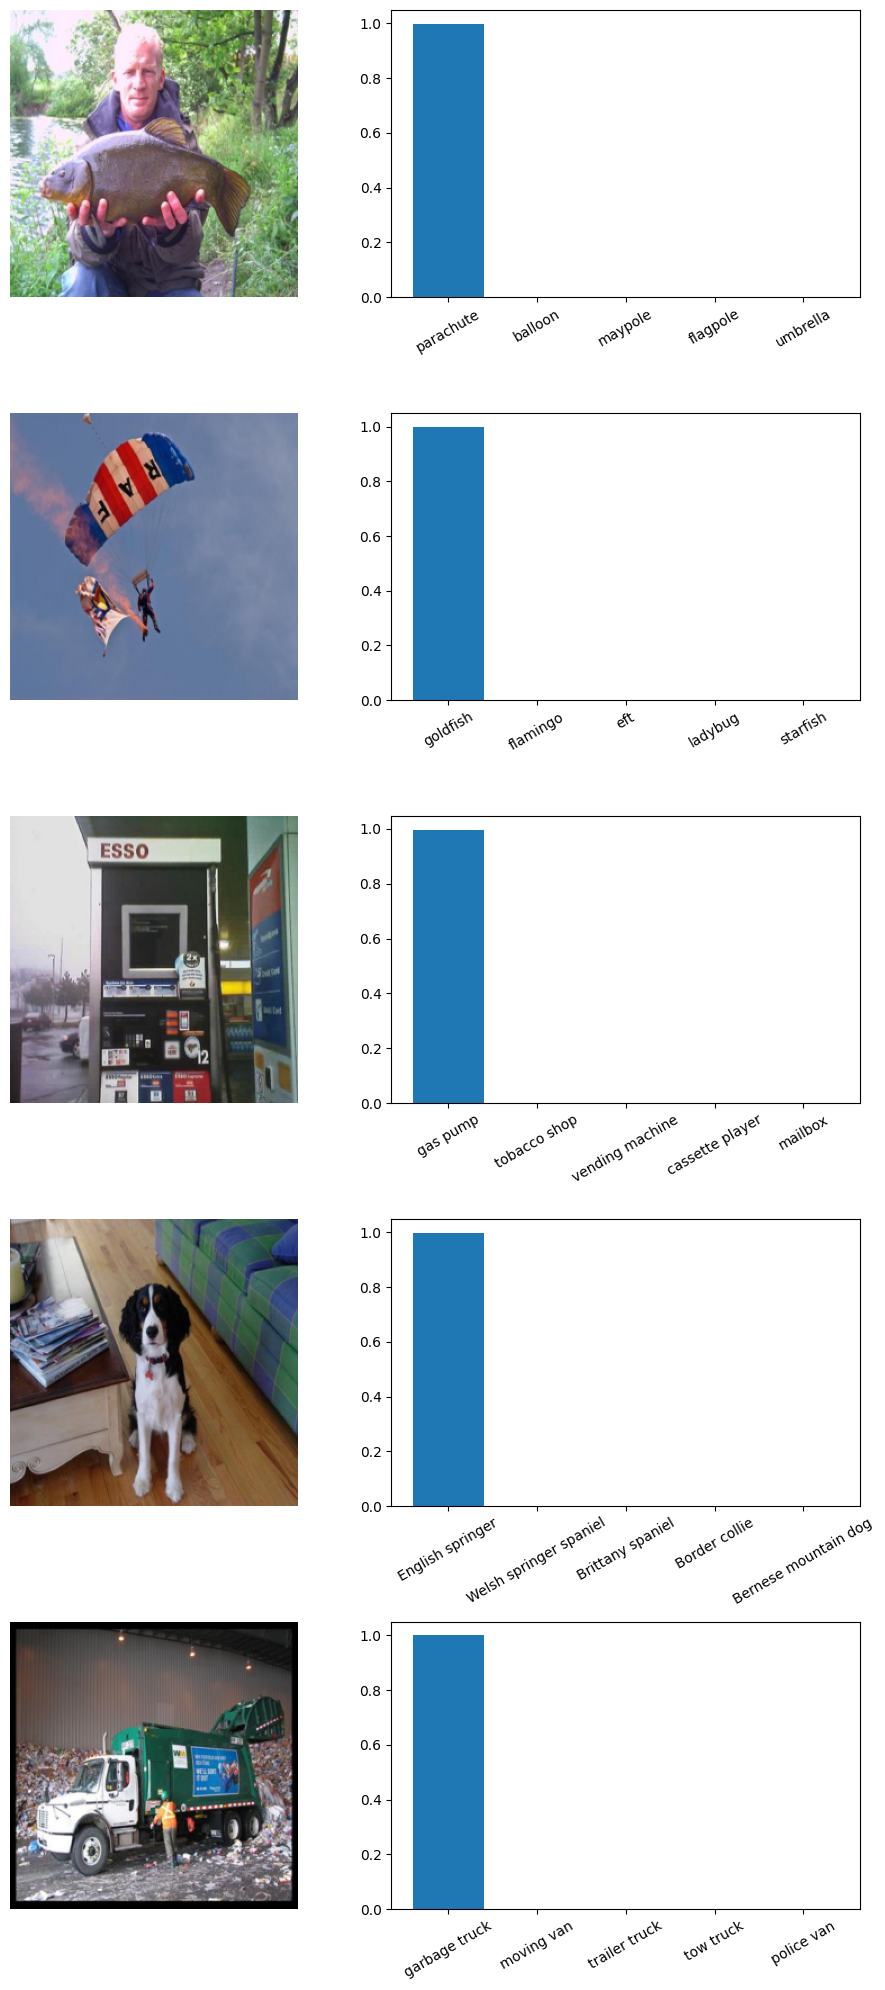

In [40]:
# Visualize probabilities of top 5 predictions
fig, ax = plt.subplots(5, 2, figsize=(10, 20))

for i in range(5):
  ax[i, 0].imshow(np.moveaxis(images[i].numpy(), 0, -1))
  ax[i, 0].axis('off')

  ax[i, 1].bar(np.arange(5), top5_probs[:, i])
  ax[i, 1].set_xticks(np.arange(5))
  ax[i, 1].set_xticklabels(top5_names[i], rotation=30)

fig.tight_layout()
plt.show()

### Q 2.2.3: Out-of-dist (4 pts)

The code below runs two out-of-distribution examples through the trained ResNet. Look at the predictions and answer below: why might the model fail to make accurate predictions on these images?

In [ ]:
loc = 'https://raw.githubusercontent.com/NeuromatchAcademy/course-content-dl/main/tutorials/W2D3_ModernConvnets/static/'

fname1 = 'bonsai-svg-5.png'
response = requests.get(loc + fname1)
image = Image.open(BytesIO(response.content)).resize((256, 256))
data = torch.from_numpy(np.asarray(image)[:, :, :3]) / 255.

fname2 = 'Pokémon_Pikachu_art.png'
response = requests.get(loc + fname2)
image = Image.open(BytesIO(response.content)).resize((256, 256))
data2 = torch.from_numpy(np.asarray(image)[:, :, :3]) / 255.

images = torch.stack([data, data2]).permute(0, 3, 1, 2)

In [ ]:
# Retrieve top 5 predictions
top5_names, top5_probs = predict_top5(images, DEVICE, SEED)

In [ ]:
# Visualize probabilities of top 5 predictions
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

for i in range(2):
  ax[i, 0].imshow(np.moveaxis(images[i].numpy(), 0, -1))
  ax[i, 0].axis('off')

  ax[i, 1].bar(np.arange(5), top5_probs[:, i])
  ax[i, 1].set_xticks(np.arange(5))
  ax[i, 1].set_xticklabels(top5_names[i], rotation=30)

fig.tight_layout()
plt.show()

**Your answer here.**

## 2.3: Transfer Learning



The most common way large image models are trained in practice is via transfer learning. One first pretrains a network on a large classification dataset like ImageNet, then uses the weights of this network as initialization for training ("fine-tuning") that network on your task of choice.

While training a network twice sounds like a strange thing to do, the model ends up training faster on the target dataset and often outperforms training "from scratch". There are also other benefits such as [robustness to noise](https://arxiv.org/pdf/1901.09960.pdf) that are the subject of [active research](https://arxiv.org/abs/2008.11687).

In this section we will explore transfer learning by taking a ResNet trained on ImageNet and teaching it to classify Pokemon.

In [ ]:
# @title Download Data
import zipfile, io

# Original link: https://github.com/ben-heil/cis_522_data.git
url = 'https://osf.io/u4njm/download'

fname = 'small_pokemon_dataset'

if not os.path.exists(fname+'zip'):
  print("Data is being downloaded...")
  r = requests.get(url, stream=True)
  z = zipfile.ZipFile(io.BytesIO(r.content))
  z.extractall()
  print("The download has been completed.")
else:
  print("Data has already been downloaded.")

In [ ]:
# List the different Pokemon
os.listdir("small_pokemon_dataset/")

In [ ]:
# @title Determine number of classes
num_classes = 0
for folders in os.listdir('small_pokemon_dataset/'):
  num_classes += 1
print(f"{num_classes} types of Pokemon")

In [ ]:
# @title Display Example Images
train_transform = transforms.Compose((transforms.Resize((256, 256)),
                                      transforms.ToTensor()))

pokemon_dataset = ImageFolder('small_pokemon_dataset',
                              transform=train_transform)

image_count = len(pokemon_dataset)
train_indices = []
test_indices = []
for i in range(image_count):
  # Put ten percent of the images in the test set
  if random.random() < .1:
    test_indices.append(i)
  else:
    train_indices.append(i)

pokemon_test_set = torch.utils.data.Subset(pokemon_dataset, test_indices)
pokemon_train_set = torch.utils.data.Subset(pokemon_dataset, train_indices)

pokemon_train_loader = torch.utils.data.DataLoader(pokemon_train_set,
                                                   batch_size=16,
                                                   shuffle=True,)
pokemon_test_loader = torch.utils.data.DataLoader(pokemon_test_set,
                                                  batch_size=16)

dataiter = iter(pokemon_train_loader)
images, labels = next(dataiter)

# Show images
plt.imshow(make_grid(images, nrow=4).permute(1, 2, 0))
plt.axis('off')
plt.show()

### Pokemon

It is common in computer vision to take a large model trained on a large dataset (often ImageNet), replace the classification layer and fine-tune the entire network to perform a different task.

Here we'll be using a pre-trained ResNet model to classify types of Pokemon.

In [ ]:
resnet = torchvision.models.resnet18(weights='ResNet18_Weights.DEFAULT')
num_ftrs = resnet.fc.in_features
# Reset final fully connected layer, number of classes = types of Pokemon = 9
resnet.fc = nn.Linear(num_ftrs, num_classes)
resnet.to(DEVICE)
optimizer = torch.optim.Adam(resnet.parameters(), lr=1e-4)
loss_fn = nn.CrossEntropyLoss()

In [ ]:
# @title Finetune ResNet
# @markdown This will take a little while to run even on GPU -- hang tight and watch the plot of prediction accuracy update over 10 training epochs.
pretrained_accs = []
for epoch in tqdm.tqdm(range(10)):
  # Train loop
  for batch in pokemon_train_loader:
    images, labels = batch
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    optimizer.zero_grad()
    output = resnet(images)
    loss = loss_fn(output, labels)
    loss.backward()
    optimizer.step()

  # Eval loop
  with torch.no_grad():
    loss_sum = 0
    total_correct = 0
    total = len(pokemon_test_set)
    for batch in pokemon_test_loader:
      images, labels = batch
      images = images.to(DEVICE)
      labels = labels.to(DEVICE)
      output = resnet(images)
      loss = loss_fn(output, labels)
      loss_sum += loss.item()

      predictions = torch.argmax(output, dim=1)

      num_correct = torch.sum(predictions == labels)
      total_correct += num_correct

    # Plot accuracy
    pretrained_accs.append(total_correct.cpu() / total)
    plt.plot(pretrained_accs)
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Pokemon prediction accuracy')
    IPython.display.clear_output(wait=True)
    IPython.display.display(plt.gcf())
  plt.close()

### Train only classification layer

Another possible way to make use of transfer learning is to take a pre-trained model and replace the last layer, the classification layer (sometimes also called the "linear readout"). Instead of fine-tuning the whole model as before, we train only the classification layer.

In [ ]:
resnet = torchvision.models.resnet18(weights='ResNet18_Weights.DEFAULT')
for param in resnet.parameters():
  param.requires_grad = False
num_ftrs = resnet.fc.in_features
# ResNet final fully connected layer
resnet.fc = nn.Linear(num_ftrs, num_classes)
resnet.to(DEVICE)
optimizer = torch.optim.Adam(resnet.fc.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

In [ ]:
# @title Finetune readout of ResNet
linreadout_accs = []
for epoch in tqdm.tqdm(range(10)):
  # Train loop
  for batch in pokemon_train_loader:
    images, labels = batch
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    optimizer.zero_grad()
    output = resnet(images)
    loss = loss_fn(output, labels)
    loss.backward()
    optimizer.step()

  # Eval loop
  with torch.no_grad():
    loss_sum = 0
    total_correct = 0
    total = len(pokemon_test_set)
    for batch in pokemon_test_loader:
      images, labels = batch
      images = images.to(DEVICE)
      labels = labels.to(DEVICE)
      output = resnet(images)
      loss = loss_fn(output, labels)
      loss_sum += loss.item()

      predictions = torch.argmax(output, dim=1)

      num_correct = torch.sum(predictions == labels)
      total_correct += num_correct

    # Plot accuracy
    linreadout_accs.append(total_correct.cpu() / total)
    plt.plot(linreadout_accs)
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Pokemon prediction accuracy')
    IPython.display.clear_output(wait=True)
    IPython.display.display(plt.gcf())
  plt.close()

### Training ResNet from scratch

As a baseline and for comparison reasons we will also train the ResNet "from scratch" – that is: initialize the weights randomly and train the entire network exclusively on the Pokemon dataset.

In [ ]:
resnet = torchvision.models.resnet18(weights=None)
num_ftrs = resnet.fc.in_features
# ResNet final fully connected layer
resnet.fc = nn.Linear(num_ftrs, num_classes)
resnet.to(DEVICE)
optimizer = torch.optim.Adam(resnet.parameters(), lr=1e-4)

loss_fn = nn.CrossEntropyLoss()

In [ ]:
# @title Train ResNet from scratch
scratch_accs = []
for epoch in tqdm.tqdm(range(10)):
  # Train loop
  for batch in pokemon_train_loader:
    images, labels = batch
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    optimizer.zero_grad()
    output = resnet(images)
    loss = loss_fn(output, labels)
    loss.backward()
    optimizer.step()

  # Eval loop
  with torch.no_grad():
    loss_sum = 0
    total_correct = 0
    total = len(pokemon_test_set)
    for batch in pokemon_test_loader:
      images, labels = batch
      images = images.to(DEVICE)
      labels = labels.to(DEVICE)
      output = resnet(images)
      loss = loss_fn(output, labels)
      loss_sum += loss.item()

      predictions = torch.argmax(output, dim=1)

      num_correct = torch.sum(predictions == labels)
      total_correct += num_correct

    scratch_accs.append(total_correct.cpu() / total)
    plt.plot(scratch_accs)
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Pokemon prediction accuracy')

    IPython.display.clear_output(wait=True)
    IPython.display.display(plt.gcf())
  plt.close()

### Comparison
Starting from a randomly initialized network works less well, especially in the case of small datsets. Note that the model converges more slowly and less evenly.

In [ ]:
# @title Plot Accuracies
plt.plot(pretrained_accs, label='Pretrained: fine-tuning')
plt.plot(linreadout_accs, label='Pretrained: linear Readout')
plt.plot(scratch_accs, label='Trained from Scratch')
plt.title('Pokemon prediction accuracy')
plt.legend()
plt.show()

### Q 2.3.1: Pretraining (4 pts)

Why might pretrained models outperform models trained from scratch? In what cases would you expect them to be worse?

**Your answer here.**

### Q 2.3.2: Last Layer (4 pts)

Why might fine-tuning the whole network outperform training only the classification layer? What are the benefits of training only the classification layer? In what cases would you expect a similar performance of both methods?

**Your answer here.**

## 2.4: FaceNet

In this section we will see an application of modern CNNs in facial recognition and consider some of the ethical aspects of such a model.

In [ ]:
# @title Install dependencies
# @markdown Install `facenet` - A model used to do facial recognition
!pip install facenet-pytorch --quiet
!pip install Pillow --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 949.5 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.6/755.6 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 99.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 84.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 32.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124

In [ ]:
# Imports
import glob
import torch

import numpy as np
import sklearn.decomposition
import matplotlib.pyplot as plt

from PIL import Image

from torchvision import transforms
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder

from facenet_pytorch import MTCNN, InceptionResnetV1

In [ ]:
# @title Download Faces Data
import requests, zipfile, io, os

# Original link: https://github.com/ben-heil/cis_522_data.git
url = 'https://osf.io/2kyfb/download'

fname = 'faces'

if not os.path.exists(fname+'zip'):
  print("Data is being downloaded...")
  r = requests.get(url, stream=True)
  z = zipfile.ZipFile(io.BytesIO(r.content))
  z.extractall()
  print("The download has been completed.")
else:
  print("Data has already been downloaded.")

One application of large CNNs is **facial recognition**. The problem formulation in facial recognition is a little different from the image classification we've seen so far. In facial recognition, we don't want to have a fixed number of individuals that the model can learn. If that were the case then to learn a new person it would be necessary to modify the output portion of the architecture and retrain to account for the new person.

Instead, we train a model to learn an **embedding** where images from the same individual are close to each other in an embedded space, and images corresponding to different people are far apart. When the model is trained, it takes as input an image and outputs an embedding vector corresponding to the image.

To achieve this, facial recognitions typically use a **triplet loss** that compares two images from the same individual (i.e., "anchor" and "positive" images) and a negative image from a different individual (i.e., "negative" image). The loss requires the distance between the anchor and negative points to be greater than a margin $\alpha$ + the distance between the anchor and positive points.

### View and transform the data

A well-trained facial recognition system should be able to map different images of the same individual relatively close together. We will load 15 images of three individuals (maybe you know them - then you can see that your brain is quite well in facial recognition).

After viewing the images, we will transform them: MTCNN ([github repo](https://github.com/ipazc/mtcnn)) detects the face and crops the image around the face. Then we stack all the images together in a tensor.

In [ ]:
# @title Display Images
# @markdown Here are the source images of Bruce Lee, Neil Patrick Harris, and Pam Grier
train_transform = transforms.Compose((transforms.Resize((256, 256)),
                                      transforms.ToTensor()))

face_dataset = ImageFolder('faces', transform=train_transform)

image_count = len(face_dataset)

face_loader = torch.utils.data.DataLoader(face_dataset,
                                          batch_size=45,
                                          shuffle=False)

dataiter = iter(face_loader)
images, labels = next(dataiter)

# Show images
plt.figure(figsize=(15, 15))
plt.imshow(make_grid(images, nrow=15).permute(1, 2, 0))
plt.axis('off')
plt.show()

In [ ]:
# @title Image Preprocessing Function
def process_images(image_dir: str, size=256):
  """
  This function returns two tensors for the
  given image dir: one usable for inputting into the
  facenet model, and one that is [0,1] scaled for
  visualizing

  Parameters:
    image_dir: string
      The glob corresponding to images in a directory
    size: int
      Size [default: 256]

  Returns:
    model_tensor: torch.tensor
      A image_count x channels x height x width
      tensor scaled to between -1 and 1,
      with the faces detected and cropped to the center
      using mtcnn
    display_tensor: torch.tensor
      A transformed version of the model
      tensor scaled to between 0 and 1
  """
  mtcnn = MTCNN(image_size=size, margin=32)
  images = []
  for img_path in glob.glob(image_dir):
    img = Image.open(img_path)
    # Normalize and crop image
    img_cropped = mtcnn(img)
    images.append(img_cropped)

  model_tensor = torch.stack(images)
  display_tensor = model_tensor / (model_tensor.max() * 2)
  display_tensor += .5

  return model_tensor, display_tensor

Now that we have our images loaded, we need to preprocess them. To make the images easier for the network to learn, we crop them to include just faces.

In [ ]:
bruce_tensor, bruce_display = process_images('faces/bruce/*.jpg')
neil_tensor, neil_display = process_images('faces/neil/*.jpg')
pam_tensor, pam_display = process_images('faces/pam/*.jpg')

tensor_to_display = torch.cat((bruce_display, neil_display, pam_display))

plt.figure(figsize=(15, 15))
plt.imshow(make_grid(tensor_to_display, nrow=15).permute(1, 2, 0))
plt.axis('off')
plt.show()

### Embedding with a pretrained network

We'll load a pretrained facial recognition model called [FaceNet](https://github.com/timesler/facenet-pytorch). It was trained on the [VGGFace2](https://github.com/ox-vgg/vgg_face2) dataset which contains 3.31 million images of 9131 individuals.

We'll use this pretrained model to calculate embeddings for all of our input images.

In [ ]:
resnet = InceptionResnetV1(pretrained='vggface2').eval().to(DEVICE)

In [ ]:
# Calculate embedding
resnet.classify = False
bruce_embeddings = resnet(bruce_tensor.to(DEVICE))
neil_embeddings = resnet(neil_tensor.to(DEVICE))
pam_embeddings = resnet(pam_tensor.to(DEVICE))

### Q 2.4.1: Embeddings (6 pts)

We want to understand what happens when the model receives an image and returns the corresponding embedding vector.

- What are the height, width and number of channels of one input image?
- What are the dimensions of one stack of images (e.g. bruce_tensor)?
- What are the dimensions of the corresponding embedding (e.g. bruce_embeddings)?
- What would be the dimensions of the embedding of one input image?


**Hints:**
- You do not have to answer the questions in the order they are asked.

In [ ]:
# write some code to help you out

**Your answers here.**

### Dimensionality Reduction

We cannot show 512-dimensional vectors visually, but using **Principal Component Analysis (PCA)** we can project the 512 dimensions onto a 2-dimensional space while preserving the maximum amount of data variation possible. This is just a visual aid for us to understand the concept. Note that if you would like to do any calculation, like distances between two images, this would be done with the whole 512-dimensional embedding vectors.

In [ ]:
embedding_tensor = torch.cat((bruce_embeddings,
                              neil_embeddings,
                              pam_embeddings)).to(device='cpu')

pca = sklearn.decomposition.PCA(n_components=2)
pca_tensor = pca.fit_transform(embedding_tensor.detach().cpu().numpy())

In [ ]:
num = 15
categs = 3
colors = ['blue', 'orange', 'magenta']
labels = ['Bruce Lee', 'Neil Patrick Harris', 'Pam Grier']
markers = ['o', 'x', 's']
plt.figure(figsize=(8, 8))
for i in range(categs):
   plt.scatter(pca_tensor[i*num:(i+1)*num, 0],
               pca_tensor[i*num:(i+1)*num, 1],
               c=colors[i],
               marker=markers[i], label=labels[i])
plt.legend()
plt.title('PCA Representation of the Image Embeddings')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.show()

Now the images corresponding to each individual are separated from each other in the embedding space!

If Neil Patrick Harris wants to unlock his phone with facial recognition, the phone takes the image from the camera, calculates the embedding and checks if it is close to the registered embeddings corresponding to Neil Patrick Harris.

### Ethics

Popular facial recognition datasets like VGGFace2 and CASIA-WebFace consist primarily of caucasian faces.
As a result, even state of the art facial recognition models [substantially underperform](https://openaccess.thecvf.com/content_ICCV_2019/papers/Wang_Racial_Faces_in_the_Wild_Reducing_Racial_Bias_by_Information_ICCV_2019_paper.pdf) when attempting to recognize faces of other races.

Given the implications that poor model performance can have in fields like security and criminal justice, it's very important to be aware of these limitations if you're going to be building facial recognition systems.

In this example we will work with a small subset from the [UTKFace](https://susanqq.github.io/UTKFace/) dataset with 49 pictures of Black women and 49 picture of white women. We will use the same pretrained model as before and consider the consequences of the model being trained on an imbalanced dataset.

In [ ]:
# @title Get data

# Original link: https://github.com/richardvogg/face_sample.git
url = 'https://osf.io/36wyh/download'
fname = 'face_sample2'

if not os.path.exists(fname+'zip'):
  print("Data is being downloaded...")
  r = requests.get(url, stream=True)
  z = zipfile.ZipFile(io.BytesIO(r.content))
  z.extractall()
  print("The download has been completed.")
else:
  print("Data has already been downloaded.")

In [ ]:
black_female_tensor, black_female_display = process_images('face_sample2/??_1_1_*.jpg', size=150)
white_female_tensor, white_female_display = process_images('face_sample2/??_1_0_*.jpg', size=150)

We can check the dimensions of these tensors and see that for each group we have images of size $150 \times 150$ and three channels (RGB) of 49 individuals.

**Note:** Originally, the size of images was $200 \times 200$, but due to RAM resources, we have reduced it. You can change it back, i.e., `size=200`.

In [ ]:
print(white_female_tensor.shape)
print(black_female_tensor.shape)

In [ ]:
# @title Visualize some example faces
tensor_to_display = torch.cat((white_female_display[:15],
                               black_female_display[:15]))

plt.figure(figsize=(12, 12))
plt.imshow(make_grid(tensor_to_display, nrow = 15).permute(1, 2, 0))
plt.axis('off')
plt.show()

### Calculate Embeddings

We use the same pretrained facial recognition network as previously to calculate embeddings.

If you run into memory issues, go to `Edit > Notebook settings` and check if GPU is selected as `Hardware accelerator`. If this does not help you can restart the notebook, go to `Runtime -> Restart runtime`. You will need to re-import imports / data / models.

In [ ]:
resnet.classify = False
black_female_embeddings = resnet(black_female_tensor.to(DEVICE))
white_female_embeddings = resnet(white_female_tensor.to(DEVICE))

### Embedding Distances

We will use the embeddings to show that the model was trained on an imbalanced dataset. For this, we are going to calculate a distance matrix of all combinations of images, like in this small example with $n=3$ (in our case $n=98$).

<img height=500 src=https://raw.githubusercontent.com/richardvogg/face_sample/main/04_DistanceMatrix.png>

The following cells calculate the distance between each pair of image embeddings in our tensor and visualize all the distances. Remember that two embeddings are vectors and the distance between two vectors is the Euclidean distance.

In [ ]:
# @title Function to calculate pairwise distances

# @markdown [`torch.cdist`](https://pytorch.org/docs/stable/generated/torch.cdist.html) is used

def calculate_pairwise_distances(embedding_tensor):
  """
  This function calculates the distance
  between each pair of image embeddings
  in a tensor using the `torch.cdist`.

  Parameters:
    embedding_tensor : torch.Tensor
      A num_images x embedding_dimension tensor

  Returns:
    distances : torch.Tensor
      A num_images x num_images tensor
      containing the pairwise distances between
      each to image embedding
  """

  distances = torch.cdist(embedding_tensor, embedding_tensor)

  return distances

In [ ]:
# @title Visualize the distances

embedding_tensor = torch.cat((black_female_embeddings,
                              white_female_embeddings)).to(device='cpu')

distances = calculate_pairwise_distances(embedding_tensor)

plt.figure(figsize=(8, 8))
plt.imshow(distances.detach().cpu().numpy())
plt.annotate('Black female', (2, -0.5), fontsize=20, va='bottom')
plt.annotate('White female', (52, -0.5), fontsize=20, va='bottom')
plt.annotate('Black female', (-0.5, 45), fontsize=20, rotation=90, ha='right')
plt.annotate('White female', (-0.5, 90), fontsize=20, rotation=90, ha='right')
cbar = plt.colorbar()
cbar.set_label('Distance', fontsize=16)
plt.axis('off')
plt.show()

### Q 2.4.2: Face Similarity (2 pts)

What do you observe? The faces of which group are more similar to each other for the Face Detection algorithm?

**Your answers here.**

### Q 2.4.3: Embeddings (6 pts)

- What does it mean in real life applications that the distance is smaller between the embeddings of one group?
- Can you come up with example situations/applications where this has a negative impact?
- What could you do to avoid these problems?

**Your answers here.**

### Different Datasets

Lastly, to show the importance of the dataset which you use to pretrain your model, look at how much space white men and women take in different embeddings. *FairFace* is a dataset which is specifically created with completely balanced classes. The blue dots in all visualizations are white male and white female.

<img src=https://i.imgur.com/hCdCBOa.png>

Adopted from [Kärkkäinen and Joo, 2019, arXiv](https://arxiv.org/abs/1908.04913)

# Part 3: Visualization



In this section we will explore the use of *image gradients* for generating new images.

When training a model, we define a loss function which measures our current unhappiness with the model's performance. We then use backpropagation to compute the gradient of the loss with respect to the model parameters and perform gradient descent on the model parameters to minimize the loss.

Here we will do something slightly different. We will start from a CNN model which has been pretrained to perform image classification on the ImageNet dataset. We will use this model to define a loss function which quantifies our current unhappiness with our image. Then we will use backpropagation to compute the gradient of this loss with respect to the pixels of the image. We will then keep the model fixed and perform gradient descent *on the image* to synthesize a new image which minimizes the loss.

We will explore two techniques for image generation (there exist many others).

**Saliency Maps.** We can use saliency maps to tell which part of the image influenced the classification decision made by the network.

**Fooling Images.** We can perturb an input image so that it appears the same to humans but will be misclassified by the pretrained network.

In [ ]:
# notes from Apr 1 lab
# we work on a high-dim system, want to see how the structure wires differently for different functions;
# (1) data covariance matrix: of the responses of the model itself -- find eigvals & eigvecs, find top PCs, find factors represented in the PCs
# (2) PCA: population coding.
# (3) latent space: abstract space, low-dim, adjacent points have adjacent scores / similar measurements; eg/ similar pts have similar memorability scores

## Getting Started

### Mount Google Drive

If you haven't yet done so, download the pset6.zip file and unzip it. Upload the entire folder to your Google Drive. Verify that your pset6 folder has two subfolders titled cs231n and images. Then run the following.

You may need to give permissions for Google Drive Desktop in a pop-up.

Downloading the COCO dataset may take a second.

In [ ]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

FOLDERNAME = '/pset6'

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# This downloads the COCO dataset to your Drive
# if it doesn't already exist. This may take a while!
%cd /content/drive/My\ Drive/$FOLDERNAME/cs231n/datasets/
!bash get_datasets.sh
%cd /content/drive/My\ Drive/$FOLDERNAME

### Imports

In [ ]:
import torch
import torchvision
import numpy as np
import random
import matplotlib.pyplot as plt
from PIL import Image
from cs231n.image_utils import SQUEEZENET_MEAN, SQUEEZENET_STD
from cs231n.net_visualization_pytorch import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # Set default size of plots.
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

### Pretrained Model

For all of our image generation experiments, we will start with a convolutional neural network which was pretrained to perform image classification on ImageNet. We can use any model here, but for the purposes of this assignment we will use SqueezeNet [1], which achieves accuracies comparable to AlexNet but with a significantly reduced parameter count and computational complexity.

Using SqueezeNet rather than AlexNet or VGG or ResNet means that we can easily perform all image generation experiments on CPU.

[1] Iandola et al, "SqueezeNet: AlexNet-level accuracy with 50x fewer parameters and < 0.5MB model size", arXiv 2016

In [ ]:
# Download and load the pretrained SqueezeNet model.
model = torchvision.models.squeezenet1_1(pretrained=True)

# We don't want to train the model, so tell PyTorch not to compute gradients
# with respect to model parameters.
for param in model.parameters():
    param.requires_grad = False

### Loading ImageNet Validation Images
Below we are loading a few example images from the validation set of the ImageNet ILSVRC 2012 Classification dataset. Since they come from the validation set, our pretrained model did not see these images during training. Run the following cell to visualize some of these images along with their ground-truth labels.

In [ ]:
from cs231n.data_utils import load_imagenet_val
X, y, class_names = load_imagenet_val(num=5)

plt.figure(figsize=(12, 6))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(X[i])
    plt.title(class_names[y[i]])
    plt.axis('off')
plt.gcf().tight_layout()

## 3.1: Saliency Maps
Using this pretrained model, we will compute class saliency maps.

A **saliency map** tells us the degree to which each pixel in the image affects the classification score for that image. To compute it, we compute the gradient of the score corresponding to the correct class (which is a scalar) with respect to the pixels of the image. If the image has shape `(3, H, W)` then this gradient will also have shape `(3, H, W)`.

For each pixel in the image, this gradient tells us the amount by which the classification score will change if the pixel changes by a small amount. To compute the saliency map, we take the absolute value of this gradient, then take the maximum value over the 3 input channels; the final saliency map thus has shape `(H, W)` and all entries are nonnegative.

### Hint: PyTorch `gather` method
Recall that in order to select one element from each row of a matrix, if `s` is an numpy array of shape `(N, C)` and `y` is a numpy array of shape `(N,`) containing integers `0 <= y[i] < C`, then `s[np.arange(N), y]` is a numpy array of shape `(N,)` which selects one element from each element in `s` using the indices in `y`.

In PyTorch you can perform the same operation using the `gather()` method. If `s` is a PyTorch Tensor of shape `(N, C)` and `y` is a PyTorch Tensor of shape `(N,)` containing longs in the range `0 <= y[i] < C`, then

`s.gather(1, y.view(-1, 1)).squeeze()`

will be a PyTorch Tensor of shape `(N,)` containing one entry from each row of `s`, selected according to the indices in `y`.

Run the following cell to see an example.

You can also read the documentation for [the gather method](http://pytorch.org/docs/torch.html#torch.gather)
and [the squeeze method](http://pytorch.org/docs/torch.html#torch.squeeze).

In [ ]:
# Example of using gather to select one entry from each row in PyTorch
def gather_example():
    N, C = 4, 5
    s = torch.randn(N, C)
    y = torch.LongTensor([1, 2, 1, 3])
    print(s)
    print(y)
    print(s.gather(1, y.view(-1, 1)).squeeze())
gather_example()

### Q 3.1.1: Compute Saliency (6 pts)

Implement the ```compute_saliency_maps``` function below.

In [ ]:
def compute_saliency_maps(X, y, model):
    """
    Compute a class saliency map using the model for images X and labels y.

    Input:
    - X: Input images; Tensor of shape (N, 3, H, W)
    - y: Labels for X; LongTensor of shape (N,)
    - model: A pretrained CNN that will be used to compute the saliency map.

    Returns:
    - saliency: A Tensor of shape (N, H, W) giving the saliency maps for the input
    images.
    """
    # Make sure the model is in "test" mode
    model.eval()

    # Make input tensor require gradient
    X.requires_grad_()

    saliency = None
    ##############################################################################
    # TODO: Implement this function. Perform a forward and backward pass through #
    # the model to compute the gradient of the correct class score with respect  #
    # to each input image. You first want to compute the loss over the correct   #
    # scores (we'll combine losses across a batch by summing), and then compute  #
    # the gradients with a backward pass.                                        #
    ##############################################################################
    # *****START OF YOUR CODE*****

    # Forward pass

    # Gather the scores for the correct classes

    # Backward pass

    # Compute the saliency map
    saliency = X.grad.abs().max(dim=1)[0]

    # *****END OF YOUR CODE*****
    ##############################################################################
    #                             END OF YOUR CODE                               #
    ##############################################################################
    return saliency

Once you have completed the implementation above, run the following to visualize some class saliency maps on our example images from the ImageNet validation set:

In [ ]:
def show_saliency_maps(X, y):
    # Convert X and y from numpy arrays to Torch Tensors
    X_tensor = torch.cat([preprocess(Image.fromarray(x)) for x in X], dim=0)
    y_tensor = torch.LongTensor(y)

    # Compute saliency maps for images in X
    saliency = compute_saliency_maps(X_tensor, y_tensor, model)

    # Convert the saliency map from Torch Tensor to numpy array and show images
    # and saliency maps together.
    saliency = saliency.numpy()
    N = X.shape[0]
    for i in range(N):
        plt.subplot(2, N, i + 1)
        plt.imshow(X[i])
        plt.axis('off')
        plt.title(class_names[y[i]])
        plt.subplot(2, N, N + i + 1)
        plt.imshow(saliency[i], cmap=plt.cm.hot)
        plt.axis('off')
        plt.gcf().set_size_inches(12, 5)
    plt.show()

show_saliency_maps(X, y)

### Q 3.1.2: Updates (4 pts)

A friend of yours suggests that in order to find an image that maximizes the correct score, we can perform gradient ascent on the input image, but instead of the gradient we can actually use the saliency map in each step to update the image. Is this assertion true? Why or why not?



**Your answer here.**

## 3.2: Fooling Images
We can also use image gradients to generate "fooling images" as discussed in [3]. Given an image and a target class, we can perform gradient **ascent** over the image to maximize the target class, stopping when the network classifies the image as the target class. Implement the following function to generate fooling images.

[3] Szegedy et al, "Intriguing properties of neural networks", ICLR 2014

### Q 3.2.1: Fooling Images (10 pts)

Implement the ```make_fooling_image``` function below.

In [ ]:
def make_fooling_image(X, target_y, model):
    """
    Generate a fooling image that is close to X, but that the model classifies
    as target_y.

    Inputs:
    - X: Input image; Tensor of shape (1, 3, 224, 224)
    - target_y: An integer in the range [0, 1000)
    - model: A pretrained CNN

    Returns:
    - X_fooling: An image that is close to X, but that is classifed as target_y
    by the model.
    """
    # Initialize our fooling image to the input image, and make it require gradient
    X_fooling = X.clone()
    X_fooling = X_fooling.requires_grad_()

    learning_rate = 1
    ##############################################################################
    # TODO: Generate a fooling image X_fooling that the model will classify as   #
    # the class target_y. You should perform gradient ascent on the score of the #
    # target class, stopping when the model is fooled.                           #
    # When computing an update step, first normalize the gradient:               #
    #   dX = learning_rate * g / ||g||_2                                         #
    #                                                                            #
    # You should write a training loop.                                          #
    #                                                                            #
    # HINT: For most examples, you should be able to generate a fooling image    #
    # in fewer than 100 iterations of gradient ascent.                           #
    # You can print your progress over iterations to check your algorithm.       #
    ##############################################################################
    # *****START OF YOUR CODE*****

    # Perform gradient ascent to generate the fooling image
    for i in range(100):  # Gradient ascent iterations
        scores = model(X_fooling)
        # Compute the score of the target class

        # Perform backward pass to compute gradients

        # Compute the normalized gradient

        # Update the fooling image

        # Zero out the gradients for the next iteration

    # *****END OF YOUR CODE*****
    ##############################################################################
    #                             END OF YOUR CODE                               #
    ##############################################################################
    return X_fooling

### Generate Fooling Image

Run the following two cells to generate and visualize a fooling image. You should ideally see at first glance no major difference between the original and fooling images, and the network should now make an incorrect prediction on the fooling one. However you should see a bit of random noise if you look at the 10x magnified difference between the original and fooling images. Feel free to change the `idx` variable to explore other images.

In [ ]:
idx = 0
target_y = 6

X_tensor = torch.cat([preprocess(Image.fromarray(x)) for x in X], dim=0)
X_fooling = make_fooling_image(X_tensor[idx:idx+1], target_y, model)

scores = model(X_fooling)
assert target_y == scores.data.max(1)[1][0].item(), 'The model is not fooled!'

### Visualize Together

After generating a fooling image, run the following cell to visualize the original image, the fooling image, as well as the difference between them.

In [ ]:
X_fooling_np = deprocess(X_fooling.clone())
X_fooling_np = np.asarray(X_fooling_np).astype(np.uint8)

plt.subplot(1, 4, 1)
plt.imshow(X[idx])
plt.title(class_names[y[idx]])
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(X_fooling_np)
plt.title(class_names[target_y])
plt.axis('off')

plt.subplot(1, 4, 3)
X_pre = preprocess(Image.fromarray(X[idx]))
diff = np.asarray(deprocess(X_fooling - X_pre, should_rescale=False))
plt.imshow(diff)
plt.title('Difference')
plt.axis('off')

plt.subplot(1, 4, 4)
diff = np.asarray(deprocess(10 * (X_fooling - X_pre), should_rescale=False))
plt.imshow(diff)
plt.title('Magnified difference (10x)')
plt.axis('off')

plt.gcf().set_size_inches(12, 5)
plt.show()

### Q 3.2.2: Think (4 pts)

This is an open-ended question, but what does the ability of the network to be easily fooled (by essentially what looks like a tiny amount of noise) suggest to you about the representations of the network / what it "knows"?

**Your answer here.**

# Part 4: GANs

## Getting Started

Once again, make sure your runtime type is set to GPU. Then run the following two code cells.

In [ ]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

FOLDERNAME = 'pset6/'

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# This downloads the COCO dataset to your Drive
# if it doesn't already exist.
%cd /content/drive/My\ Drive/$FOLDERNAME/cs231n/datasets/
!bash get_datasets.sh
%cd /content/drive/My\ Drive/$FOLDERNAME

In [ ]:
import numpy as np
import torch
import torch.nn as nn
from torch.nn import init
import torchvision
import torchvision.transforms as T
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as dset
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from cs231n.gan_pytorch import preprocess_img, deprocess_img, rel_error, count_params, ChunkSampler

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # Set default size of plots.
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

def show_images(images):
    images = np.reshape(images, [images.shape[0], -1]) # Images reshape to (batch_size, D).
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    return

answers = dict(np.load('gan-checks.npz'))
dtype = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

## Generative Models

Thus far (with the exception of generating fooling images above), all the neural networks that we have explored have been **discriminative models** that take an input and are trained to produce a labeled output. Now we will expand our repetoire and build **generative models**.

In 2014, [Goodfellow et al.](https://arxiv.org/abs/1406.2661) presented a method for training generative models called Generative Adversarial Networks (GANs for short). In a GAN, we build two different neural networks. Our first network is a traditional classification network, called the **discriminator**. We will train the discriminator to take images and classify them as being real (belonging to the training set) or fake (not present in the training set). Our other network, called the **generator**, will take random noise as input and transform it using a neural network to produce images. The goal of the generator is to fool the discriminator into thinking the images it produced are real.

We can think of this back and forth process of the generator ($G$) trying to fool the discriminator ($D$) and the discriminator trying to correctly classify real vs. fake as a minimax game:
$$\underset{G}{\text{minimize}}\; \underset{D}{\text{maximize}}\; \mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] + \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$
where $z \sim p(z)$ are the random noise samples, $G(z)$ are the generated images using the neural network generator $G$, and $D$ is the output of the discriminator, specifying the probability of an input being real.

To optimize this minimax game, we will alternate between taking gradient *descent* steps on the objective for $G$ and gradient *ascent* steps on the objective for $D$:
1. update the **generator** ($G$) to minimize the probability of the __discriminator making the correct choice__.
2. update the **discriminator** ($D$) to maximize the probability of the __discriminator making the correct choice__.

While these updates are useful for analysis, they do not perform well in practice. Instead, we will use a different objective when we update the generator: maximize the probability of the **discriminator making the incorrect choice**. This small change helps to allevaiate problems with the generator gradient vanishing when the discriminator is confident. This is the standard update used in most GAN papers and was used in the original paper from [Goodfellow et al.](https://arxiv.org/abs/1406.2661).

For our GAN, we will alternate the following updates:
1. Update the generator ($G$) to maximize the probability of the discriminator making the incorrect choice on generated data:
$$\underset{G}{\text{maximize}}\;  \mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$
2. Update the discriminator ($D$), to maximize the probability of the discriminator making the correct choice on real and generated data:
$$\underset{D}{\text{maximize}}\; \mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] + \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$

In [ ]:
# Run this cell to see sample outputs from different types of GANs trained on generating fake MNIST digits.
from IPython.display import Image
Image('images/gan_outputs_pytorch.png')

## Dataset
 GANs are notoriously finicky with hyperparameters, and also require many training epochs. In order to make this part of the pset approachable, we will be working on the MNIST dataset, which is 60,000 training and 10,000 test images. As you're no doubt already familiar with, each picture contains a centered image of white digit on black background (0 through 9).

To simplify our code here, we will use the PyTorch MNIST wrapper, which downloads and loads the MNIST dataset. See the [documentation](https://github.com/pytorch/vision/blob/master/torchvision/datasets/mnist.py) for more information about the interface. The default parameters will take 5,000 of the training examples and place them into a validation dataset. The data will be saved into a subfolder (in your Google Drive pset6/datasets/ folder) called `MNIST_data`.

In [ ]:
NUM_TRAIN = 50000
NUM_VAL = 5000

NOISE_DIM = 96
batch_size = 128

mnist_train = dset.MNIST(
    './cs231n/datasets/MNIST_data',
    train=True,
    download=True,
    transform=T.ToTensor()
)
loader_train = DataLoader(
    mnist_train,
    batch_size=batch_size,
    sampler=ChunkSampler(NUM_TRAIN, 0)
)

mnist_val = dset.MNIST(
    './cs231n/datasets/MNIST_data',
    train=True,
    download=True,
    transform=T.ToTensor()
)
loader_val = DataLoader(
    mnist_val,
    batch_size=batch_size,
    sampler=ChunkSampler(NUM_VAL, NUM_TRAIN)
)

iterator = iter(loader_train)
imgs, labels = next(iterator)
imgs = imgs.view(batch_size, 784).numpy().squeeze()
show_images(imgs)

## Q 4.1 Random Noise (4 pts)

First we will generate uniform noise from -1 to 1 with shape `[batch_size, dim]`.

Implement `sample_noise` below.

Hint: use `torch.rand`.

In [ ]:
def sample_noise(batch_size, dim, seed=None):
    """
    Generate a PyTorch Tensor of uniform random noise.

    Input:
    - batch_size: Integer giving the batch size of noise to generate.
    - dim: Integer giving the dimension of noise to generate.

    Output:
    - A PyTorch Tensor of shape (batch_size, dim) containing uniform
      random noise in the range (-1, 1).
    """
    if seed is not None:
        torch.manual_seed(seed)

    # *****START OF YOUR CODE*****

    # Generate uniform random noise in the range (-1, 1)

    # *****END OF YOUR CODE*****

    return noise

Make sure noise is the correct shape and type:

In [ ]:
def test_sample_noise():
    batch_size = 3
    dim = 4
    torch.manual_seed(231)
    z = sample_noise(batch_size, dim)
    np_z = z.cpu().numpy()
    assert np_z.shape == (batch_size, dim)
    assert torch.is_tensor(z)
    assert np.all(np_z >= -1.0) and np.all(np_z <= 1.0)
    assert np.any(np_z < 0.0) and np.any(np_z > 0.0)
    print('All tests passed!')

test_sample_noise()

## Flatten

Recall our Flatten operation from previously... this time we also provide an Unflatten, which you might want to use when implementing the convolutional generator.

In [ ]:
from cs231n.gan_pytorch import Flatten, Unflatten, initialize_weights

## Q 4.2: Discriminator (5 pts)

Our first step is to build a discriminator. Fill in the architecture as part of the `nn.Sequential` constructor in the function below. All fully connected layers should include bias terms. The architecture is:
 * Fully connected layer with input size 784 and output size 256
 * LeakyReLU with alpha 0.01
 * Fully connected layer with input_size 256 and output size 256
 * LeakyReLU with alpha 0.01
 * Fully connected layer with input size 256 and output size 1

Recall that the Leaky ReLU nonlinearity computes $f(x) = \max(\alpha x, x)$ for some fixed constant $\alpha$; for the LeakyReLU nonlinearities in the architecture above we set $\alpha=0.01$.

The output of the discriminator should have shape `[batch_size, 1]`, and contain real numbers corresponding to the scores that each of the `batch_size` inputs is a real image.

In [ ]:
def discriminator(seed=None):
    """
    Build and return a PyTorch model implementing the architecture above.
    """

    if seed is not None:
        torch.manual_seed(seed)

    model = None

    ##############################################################################
    # TODO: Implement architecture                                               #
    #                                                                            #
    # HINT: nn.Sequential might be helpful. You'll start by calling Flatten().   #
    ##############################################################################
    # *****START OF YOUR CODE*****

    model = nn.Sequential(
        Flatten(),
        nn.Linear(784,256),
        nn.LeakyReLu(),

    )

    # Define the discriminator architecture

    # *****END OF YOUR CODE*****
    ##############################################################################
    #                               END OF YOUR CODE                             #
    ##############################################################################
    return model

Test to make sure the number of parameters in the discriminator is correct:

In [ ]:
def test_discriminator(true_count=267009):
    model = discriminator()
    cur_count = count_params(model)
    if cur_count != true_count:
        print('Incorrect number of parameters in discriminator. Check your achitecture.')
    else:
        print('Correct number of parameters in discriminator.')

test_discriminator()

## Q 4.3: Generator (5 pts)
Now to build the generator network:
 * Fully connected layer from noise_dim to 1024
 * `ReLU`
 * Fully connected layer with size 1024
 * `ReLU`
 * Fully connected layer with size 784
 * `TanH` (to clip the image to be in the range of [-1,1])

In [ ]:
def generator(noise_dim=NOISE_DIM, seed=None):
    """
    Build and return a PyTorch model implementing the architecture above.
    """

    if seed is not None:
        torch.manual_seed(seed)

    model = None

    ##############################################################################
    # TODO: Implement architecture                                               #
    #                                                                            #
    # HINT: nn.Sequential might be helpful.                                      #
    ##############################################################################
    # *****START OF YOUR CODE*****

    model = nn.Sequential(
        nn.Linear(noise_dim, 1024),
        nn.ReLU(),
        ...
        Unflatten(),
    )

    # Define the generator architecture

    # *****END OF YOUR CODE*****
    ##############################################################################
    #                               END OF YOUR CODE                             #
    ##############################################################################
    return model

Test to make sure the number of parameters in the generator is correct:

In [ ]:
def test_generator(true_count=1858320):
    model = generator(4)
    cur_count = count_params(model)
    if cur_count != true_count:
        print('Incorrect number of parameters in generator. Check your achitecture.')
    else:
        print('Correct number of parameters in generator.')

test_generator()

## Q 4.4: GAN Loss (10 pts)

Compute the generator and discriminator loss. The generator loss is:
$$\ell_G  =  -\mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$
and the discriminator loss is:
$$ \ell_D = -\mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] - \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$
Note that these are negated from the equations presented earlier as we will be *minimizing* these losses.

**HINTS**: You should use the `bce_loss` function defined below to compute the binary cross entropy loss which is needed to compute the log probability of the true label given the logits output from the discriminator. Given a score $s\in\mathbb{R}$ and a label $y\in\{0, 1\}$, the binary cross entropy loss is

$$ bce(s, y) = -y * \log(s) - (1 - y) * \log(1 - s) $$

A naive implementation of this formula can be numerically unstable, so you've been provided with a numerically stable implementation that relies on PyTorch's `nn.BCEWithLogitsLoss`.

You will also need to compute labels corresponding to real or fake and use the logit arguments to determine their size. Make sure you cast these labels to the correct data type using the global `dtype` variable, for example:

`true_labels = torch.ones(size).type(dtype)`

Instead of computing the expectation of $\log D(G(z))$, $\log D(x)$ and $\log \left(1-D(G(z))\right)$, we will be averaging over elements of the minibatch. This is taken care of in `bce_loss` which combines the loss by averaging.

Implement `discriminator_loss` and `generator_loss` below.

In [ ]:
def bce_loss(input, target):
    """
    Numerically stable version of the binary cross-entropy loss function in PyTorch.

    Inputs:
    - input: PyTorch Tensor of shape (N, ) giving scores.
    - target: PyTorch Tensor of shape (N,) containing 0 and 1 giving targets.

    Returns:
    - A PyTorch Tensor containing the mean BCE loss over the minibatch of input data.
    """
    bce = nn.BCEWithLogitsLoss()
    return bce(input.squeeze(), target)

def discriminator_loss(logits_real, logits_fake):
    """
    Computes the discriminator loss described above.

    Inputs:
    - logits_real: PyTorch Tensor of shape (N,) giving scores for the real data.
    - logits_fake: PyTorch Tensor of shape (N,) giving scores for the fake data.

    Returns:
    - loss: PyTorch Tensor containing (scalar) the loss for the discriminator.
    """
    loss = None

    true_labels = torch.ones(logits_real.size(0)).type(dtype)  # Ensure target shape matches input shape
    # Labels for fake data
    fake_labels = torch.zeros(logits_fake.size(0)).type(dtype)

    # *****START OF YOUR CODE*****
    # Compute loss for real and fake data separately
    loss_real = ...
    loss_fake = ...

    # Total loss is the sum of losses for real and fake data
    loss = ...

    # *****END OF YOUR CODE*****
    return loss

def generator_loss(logits_fake):
    """
    Computes the generator loss described above.

    Inputs:
    - logits_fake: PyTorch Tensor of shape (N,) giving scores for the fake data.

    Returns:
    - loss: PyTorch Tensor containing the (scalar) loss for the generator.
    """
    loss = None
    # *****START OF YOUR CODE*****

    # *****END OF YOUR CODE*****
    return loss

Test your generator and discriminator loss. You should see errors < 1e-7.

In [ ]:
def test_discriminator_loss(logits_real, logits_fake, d_loss_true):
    d_loss = discriminator_loss(torch.Tensor(logits_real).type(dtype),
                                torch.Tensor(logits_fake).type(dtype)).cpu().numpy()
    print("Maximum error in d_loss: %g"%rel_error(d_loss_true, d_loss))

test_discriminator_loss(
    answers['logits_real'],
    answers['logits_fake'],
    answers['d_loss_true']
)

In [ ]:
def test_generator_loss(logits_fake, g_loss_true):
    g_loss = generator_loss(torch.Tensor(logits_fake).type(dtype)).cpu().numpy()
    print("Maximum error in g_loss: %g"%rel_error(g_loss_true, g_loss))

test_generator_loss(
    answers['logits_fake'],
    answers['g_loss_true']
)

## Q 4.5: Optimizing Loss (4 pts)
Complete the function below that returns an `optim.Adam` optimizer for the given model with a 1e-3 learning rate, beta1=0.5, beta2=0.999. You'll use this to construct optimizers for the generators and discriminators for the rest of the pset.

In [ ]:
def get_optimizer(model):
    """
    Construct and return an Adam optimizer for the model with learning rate 1e-3,
    beta1=0.5, and beta2=0.999.

    Input:
    - model: A PyTorch model that we want to optimize.

    Returns:
    - An Adam optimizer for the model with the desired hyperparameters.
    """
    optimizer = None
    # *****START OF YOUR CODE*****

    # *****END OF YOUR CODE*****
    return optimizer

## Training a GAN!

Below the next code cell is the main training loop. You won't need to change the `run_a_gan` function (run it to be able to use it), but I encourage you to read through it for your own understanding.

In [ ]:
def run_a_gan(D, G, D_solver, G_solver, discriminator_loss, generator_loss, loader_train, show_every=250,
              batch_size=128, noise_size=96, num_epochs=10):
    """
    Train a GAN!

    Inputs:
    - D, G: PyTorch models for the discriminator and generator
    - D_solver, G_solver: torch.optim Optimizers to use for training the
      discriminator and generator.
    - discriminator_loss, generator_loss: Functions to use for computing the generator and
      discriminator loss, respectively.
    - show_every: Show samples after every show_every iterations.
    - batch_size: Batch size to use for training.
    - noise_size: Dimension of the noise to use as input to the generator.
    - num_epochs: Number of epochs over the training dataset to use for training.
    """
    images = []
    iter_count = 0
    for epoch in range(num_epochs):
        for x, _ in loader_train:
            if len(x) != batch_size:
                continue
            D_solver.zero_grad()
            real_data = x.type(dtype)
            logits_real = D(2* (real_data - 0.5)).type(dtype)

            g_fake_seed = sample_noise(batch_size, noise_size).type(dtype)
            fake_images = G(g_fake_seed).detach()
            logits_fake = D(fake_images.view(batch_size, 1, 28, 28))

            d_total_error = discriminator_loss(logits_real, logits_fake)
            d_total_error.backward()
            D_solver.step()

            G_solver.zero_grad()
            g_fake_seed = sample_noise(batch_size, noise_size).type(dtype)
            fake_images = G(g_fake_seed)

            gen_logits_fake = D(fake_images.view(batch_size, 1, 28, 28))
            g_error = generator_loss(gen_logits_fake)
            g_error.backward()
            G_solver.step()

            if (iter_count % show_every == 0):
                print('Iter: {}, D: {:.4}, G:{:.4}'.format(iter_count,d_total_error.item(),g_error.item()))
                imgs_numpy = fake_images.data.cpu().numpy()
                images.append(imgs_numpy[0:16])

            iter_count += 1

    return images

In [ ]:
# Make the discriminator
D = discriminator().type(dtype)

# Make the generator
G = generator().type(dtype)

# Use the function you wrote earlier to get optimizers for the Discriminator and the Generator
D_solver = get_optimizer(D)
G_solver = get_optimizer(G)

# Run it!
images = run_a_gan(
    D,
    G,
    D_solver,
    G_solver,
    discriminator_loss,
    generator_loss,
    loader_train
)

Run the cell below to show the generated images.

In [ ]:
numIter = 0
for img in images:
    print("Iter: {}".format(numIter))
    show_images(img)
    plt.show()
    numIter += 250
    print()

## Q 4.6: Final Image (2 pts)

What does your final GAN image look like?

In [ ]:
# This output is your answer.
print("GAN final image:")
# depending on your setup, you may need to use the following line to reshape your images, or reshape accordingly
# images = np.reshape(images,(16,batch_size,28,28))
show_images(images[-1])
plt.show()

## Q 4.7: Iterations (4 pts)

Try playing around with the number of iterations. In the iterations in the low 100s you should see black backgrounds, fuzzy shapes as you approach iteration 1000, and decent shapes, about half of which will be sharp and clearly recognizable as we pass 3000. Record some of your observations.

**Your answer here.**

# CONGRATULATIONS

That's a wrap on problem sets for the semester :))))))) Fantastic work on all of them.

Next up is using the methods you've learned (whether they're ones we've covered in-depth or ones we've only briefly touched upon that you want to dive into further) in order to conduct a final project driven by your own curiosity. We'll also take another minute to get familiar with the Pomona HPC.

I'm super looking forward to seeing what you come up with!!